# Karolina Kruzel, ING 2019
### Temat 2
Przewidywanie wzięcia pożyczki. Celem projektu jest zastosowanie modeli klasyfikacji (binarnej) do przewidzenia czy pożyczka zostanie udzielona danemu klientowi z danymi parametrami wniosku. 
* Link do danych: https://raw.githubusercontent.com/saimadhu-polamuri/DataHakthon3X/master/dataSet/Train.csv
* Opis danych (najdokładniejszy jaki istnieje): https://discuss.analyticsvidhya.com/t/hackathon-3-x-predict-customer-worth-for-happy-customer-bank/3802
* Zmienna celu (wypłacenie pożyczki): Disbursed 

__Wymogi:__
* Zmienna LoggedIn nie może być uwzględniona w modelowaniu - należy ją od razu wyrzucić ze zbioru.
* Nie usuwamy żadnych obserwacji - braki danych uzupełniamy w jakiś sposób.
* Wszelkie nieoczywiste przekształcenia danych należy opatrzyć uzasadnieniem dlaczego dokonujemy tego przekształcenia (np. robimy wykres i uzasadniamy wzięci logarytmu ze zmiennej tym, że rozkład jest skośny).
* Należy wykorzystać przynajmniej 3 metody klasyfikacji.
* Należy uwzględnić optymalizację modeli/pipelinów.
* Projekt musi być zakończony przejrzystym porównaniem przetestowanych rozwiązań (modeli/pipelinów) w postaci tabeli, gdzie jeden wiersz opisuje jedno rozwiązanie i jego wynik.

# Wczytanie i obróbka danych

In [198]:
# Importowanie potrzebnych pakietów:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
# import math

from sklearn.pipeline import make_pipeline, Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler, StandardScaler, OneHotEncoder, scale, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.utils import class_weight
from sklearn.metrics import accuracy_score, roc_curve, f1_score, roc_auc_score, classification_report
from xgboost.sklearn import XGBClassifier
from scipy.stats import norm
from scipy import stats
from sklearn.svm import SVC

from warnings import filterwarnings
filterwarnings("ignore")

# Ustawienia wyświetlania data frame'ów:
pd.set_option('display.max_columns', 50) # żeby nie ucinało kolumn przy wyświetlaniu
pd.set_option('float_format', '{:.2f}'.format) # floaty mają się zaogrąglać do dwóch miejść po przecinku

Buduję funkcje do wczytania danych, podziału danych na zbiór testowy i treningowy oraz funkcji do drukowania opisu danych (będzie wygodna do monitoringu zmian w danych po kolejnych transformacjach) 

In [2]:
URL = 'https://raw.githubusercontent.com/saimadhu-polamuri/DataHakthon3X/master/dataSet/Train.csv'

def extract(url: str) -> pd.DataFrame:
    if url[:8] == 'https://' and url[-4:] == '.csv':
        return pd.read_csv(url, encoding='latin1', skipinitialspace=True)
    else:
        raise UnsupportedFormatError

def split_data(data: pd.DataFrame) -> pd.DataFrame:
    y = data.Disbursed
    X = data.drop(['Disbursed'], axis=1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
    return X_train, X_test, y_train, y_test

def print_df_description(df: pd.DataFrame) -> pd.DataFrame:
    df_size = df.shape[0]
    col_types = [df[column].dtype for column in df.columns]
    count_nan = [df[column].isna().sum(axis=0) for column in df.columns]
    nan_percentage = [n / df_size * 100 for n in count_nan]
    count_zeros = [(df.shape[0] - len(df[column].nonzero()[0])) for column in df.columns]
    zeros_percentage = [z / df_size * 100 for z in count_zeros]
    unique_values_num = [np.unique(df[column].astype(str)).size for column in df.columns]
    unique_values = [np.unique(df[column].astype(str)) for column in df.columns]
    df_describe = pd.DataFrame({
        'Column_names': df.columns, 'Column_types': col_types, 
        'Num_of_NaN': count_nan, 'NaN_%': nan_percentage, 
        'Num_of_zeros': count_zeros, 'Zeros_%': zeros_percentage, 
        'Unique_val_amt': unique_values_num, 'Unique_values': unique_values})
    return df_describe

In [3]:
data = extract(URL) # wczytanie danych z linku poprzez funkcję własną
X_train, X_test, y_train, y_test = split_data(data) # podział danych na zbiór treningowy i testowy

In [4]:
# sprawdzenie, ile jest 0 i 1 w zbiorach testowych i treningowych
pd.DataFrame({
    'Zbiór treningowy': [y_train.value_counts()[0], y_train.value_counts()[1]], 
    '% train': [y_train.value_counts(1)[0]*100, y_train.value_counts(1)[1]*100], 
    'Zbiór testowy': [y_test.value_counts()[0], y_test.value_counts()[1]], 
    '% test': [y_test.value_counts(1)[0]*100, y_test.value_counts(1)[1]*100]})

,Zbiór treningowy,% train,Zbiór testowy,% test
0,68598,98.54,17149,98.53
1,1018,1.46,255,1.47


Mamy problem `niezbalansowania danych` - jedynek w zbiorze jest < 1,5% => trzeba będzie to obsłużyć. Danych jest bardzo dużo, więc `oversampling` byłby zbyt mocno obciążający obliczeniowo, więc lepiej zastosować wagi dla zmiennych przy modelowaniu.

In [5]:
X_train.head() # sprawdzenie jak wyglądają dane treningowe

,ID,Gender,City,Monthly_Income,DOB,Lead_Creation_Date,Loan_Amount_Applied,Loan_Tenure_Applied,Existing_EMI,Employer_Name,Salary_Account,Mobile_Verified,Var5,Var1,Loan_Amount_Submitted,Loan_Tenure_Submitted,Interest_Rate,Processing_Fee,EMI_Loan_Submitted,Filled_Form,Device_Type,Var2,Source,Var4,LoggedIn
71841,ID103136U10,Male,Visakhapatnam,20000,14-Sep-71,18-Jul-15,200000.00,5.00,0.00,K. VENKATAREDDY & ASSOCIATES,State Bank of India,Y,0,HBXX,200000.00,2.00,nan,nan,nan,N,Web-browser,G,S122,1,0
32018,ID045846I10,Female,Bengaluru,120000,01-May-80,06-Jun-15,2000000.00,4.00,18000.00,JSS ACADEMY OF TECHNICAL EDUCATION,Corporation bank,N,16,HBXX,nan,nan,nan,nan,nan,N,Web-browser,B,S143,3,0
25270,ID036176K10,Male,Delhi,45000,26-Jan-88,29-May-15,300000.00,1.00,1000.00,IBOSS TECH SOLUTIONS,HDFC Bank,Y,15,HBXX,300000.00,1.00,nan,nan,nan,N,Web-browser,B,S159,3,0
69190,ID099333N30,Female,Kanpur,9464,16-Dec-94,16-Jul-15,0.00,0.00,0.00,HOME CREDIT INDIA FINANCE PVT LTD,Axis Bank,N,0,HBXX,nan,nan,nan,nan,nan,N,Mobile,G,S122,1,0
18924,ID027151H10,Female,Bhiwani,19000,15-Jun-90,22-May-15,500000.00,5.00,0.00,AMIT KUMAR,Canara Bank,N,1,HBXX,nan,nan,nan,nan,nan,N,Web-browser,B,S133,3,0


In [6]:
X_train.describe() # podstawowy opis danych treningowych

,Monthly_Income,Loan_Amount_Applied,Loan_Tenure_Applied,Existing_EMI,Var5,Loan_Amount_Submitted,Loan_Tenure_Submitted,Interest_Rate,Processing_Fee,EMI_Loan_Submitted,Var4,LoggedIn
count,69616.00,69560.00,69560.00,69560.00,69616.00,41994.00,41994.00,22186.00,21945.00,22186.00,69616.00,69616.00
mean,54286.16,230642.73,2.13,3701.37,4.98,394375.86,3.89,19.20,5117.95,10995.04,2.95,0.03
std,1847002.39,355480.05,2.01,39163.57,5.68,307567.84,1.17,5.84,4699.83,7483.91,1.70,0.17
min,0.00,0.00,0.00,0.00,0.00,50000.00,1.00,11.99,200.00,1176.41,0.00,0.00
25%,16500.00,0.00,0.00,0.00,0.00,200000.00,3.00,15.25,2000.00,6491.83,1.00,0.00
50%,25000.00,100000.00,2.00,0.00,2.00,300000.00,4.00,18.00,3960.00,9392.97,3.00,0.00
75%,40000.00,300000.00,4.00,3500.00,11.00,500000.00,5.00,20.00,6250.00,12935.87,5.00,0.00
max,444554443.00,10000000.00,10.00,10000000.00,18.00,3000000.00,6.00,37.00,50000.00,144748.28,7.00,1.00


In [7]:
print_df_description(X_train) # funkcja własna - opis typów danych, liczby NaN'ów, zer i unikalnych wartości

,Column_names,Column_types,Num_of_NaN,NaN_%,Num_of_zeros,Zeros_%,Unique_val_amt,Unique_values
0,ID,object,0,0.00,0,0.00,69616,"[ID000007H20, ID000009J40, ID000012M20, ID0000..."
1,Gender,object,0,0.00,0,0.00,2,"[Female, Male]"
2,City,object,788,1.13,0,0.00,683,"[ADIPUR, AHMEDB, AMALSAD, ANJAR, Abohar, Adila..."
3,Monthly_Income,int64,0,0.00,244,0.35,4990,"[0, 1, 10, 100, 1000, 10000, 100000, 1000000, ..."
4,DOB,object,0,0.00,0,0.00,10798,"[01-Apr-57, 01-Apr-60, 01-Apr-61, 01-Apr-62, 0..."
5,Lead_Creation_Date,object,0,0.00,0,0.00,92,"[01-Jul-15, 01-Jun-15, 01-May-15, 02-Jul-15, 0..."
6,Loan_Amount_Applied,float64,56,0.08,23019,33.07,248,"[0.0, 100.0, 1000.0, 10000.0, 100000.0, 100000..."
7,Loan_Tenure_Applied,float64,56,0.08,27027,38.82,11,"[0.0, 1.0, 10.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0,..."
8,Existing_EMI,float64,56,0.08,46500,66.79,3245,"[0.0, 1.0, 1.5, 10.0, 100.0, 1000.0, 10000.0, ..."
9,Employer_Name,object,59,0.08,0,0.00,36666,[(SUPERMARKET GROCERY SUPPLIES PVT. LTD. MUMBA...


Opis danych jest bardzo ubogi - nie znam danych, zatem ciężko wyciągnąć wnioski, co do których można mieć pewność.

**Główne obserwacje i wnioski oraz wstępne założenia, które przyjmę w dalszych krokach**:
- mamy `25 zmiennych`, w tym `13 kategorycznych` i `12 numerycznych`, 
- **zmienne kategoryczne**:
    - **większośc zmiennych kategorycznych ma tylko kilka unikalnych wartości**, dzięki czemu można je "zamapować" - łatwo zamienić na zmienne numeryczne,
    - **kilka zmiennych ma bardzo wiele unikalnych wartości** - będzie trzeba się im przyjrzeć i zastanowić, czy są na tyle "czyste" że ma sens pogrupowanie ich na grupy, czy też lepiej je usunąć, ponieważ ich oczyszczenie wymagałoby bardzo dużo pracy, a nie mają istotnego znaczenia z punktu widzenia modelu,
    - **braki mają tylko dwie zmienne**, określające miasto zamieszkania oraz nazwę banku, na które wpływa pensja - w mojej ocenie 
- **zmienne numeryczne**:
    - **występuje kilka zmiennych z bardzo dużym odchyleniem standardowym** - mogą wynikać z błędów przy wpisywaniu wniosku, ale tego nie wiemy, niemniej jednak dla dobrego działania modelu należy je obsłużyć adekwatnie do rozkładu danej zmiennej,
    - **bardzo dużo zmiennym ma ogromną liczbę zer lub braków** - w mojej ocenie, zwłaszcza po zajrzeniu w dane (excel) oraz mając niewiele informacji nt. danych, braki należy uzupełnić zerami; przede wszystkim są obserwacje, gdzie klient nie wypełnił informacji nt. zarobków, wnioskowanego kredytu, ale ma wypełnione pola odnośnie przyznanego kredytu (niekoniecznie został uruchomiony) - może to oznaczać, że bank sam wysłał do niego wniosek (pomimo, że klient wcale o niego nie wnioskował),
- **jest kilka zmiennych nieopisanych (np. Var1)**, które mogą być zmiennymi agregującymi informacje z kilku zmiennych wprowadzanych we wniosku kredytowym - należy rozważyć, czy brać je do modelu, czy od razu wyrzucić (w pierwszej wersji ich nie usunę).
    
Tworzę funkcje, które będą tworzyć słowniki unikalnych wartości dla poszczególnych zmiennych i będą później wykorzystane do mapowania przy transformacji danych - schemat do transformacji będzie się tworzył wyłącznie na danych treningowych.

In [8]:
def get_unique_values(column: pd.DataFrame) -> dict:
    """
    Funkcja, która dla danej zmiennej w postaci pd.DataFrame tworzy słownik unikalnych wartości w taki sposób, 
    że kluczami będą kolejne liczby, zaś wartościami kolejne unikalne wartości zmiennej.
    Przykład.
    Dla zmiennej określającej płeć (Female / Male) wynik będzie następujący: {0: 'Female', 1: 'Male'}
    """
    unique_values = np.unique(column)
    wynik = {}
    for val in range(unique_values.size):
        wynik[val] = [unique_values[val]]
    return wynik

def get_groups(groups: dict) -> dict:
    """
    Funkcja, która stworzy schemat, dzięki któremu zmienna w pd.DataFrame będzie mogła zostać "zmapowana".
    Schemat tworzony jest na podstawie słownika, będącego wynikiem funkcji `get_unique_values`. 
    """
    wynik = {}
    for key, value in groups.items():
        for name in value:
            wynik[name] = int(key)
    return wynik

In [9]:
# przykład działania ww. funkcji:
get_unique_values(X_train['Gender']), get_groups(get_unique_values(X_train['Gender']))

({0: ['Female'], 1: ['Male']}, {'Female': 0, 'Male': 1})

Tworzę schematy, które będą mogły być wykorzystane przy transformacji danych - "uczenie" odbędzie się na danych
treningowych, a następnie identyczne schematy zostaną zastosowane na danych testowych. Są to zmienne, które nie zawierają braków i mają bardzo małą liczbę unikalnych wartości, więc oceniam, że nie ma ryzyka, że w zbiorze testowym pojawi się brak lub nowa wartość, co mogłoby spowodować błąd działania funckji `tranform`.

In [10]:
gender_schema = get_groups(get_unique_values(X_train['Gender']))
mobile_verified_schema = get_groups(get_unique_values(X_train['Mobile_Verified']))
var1_schema = get_groups(get_unique_values(X_train['Var1']))
filled_form_schema = get_groups(get_unique_values(X_train['Filled_Form']))
device_type_schema = get_groups(get_unique_values(X_train['Device_Type']))
var2_schema = get_groups(get_unique_values(X_train['Var2']))

# tworzę ręcznie słownik dla zmapowania miesięcy, które w zmiennej są wpisane jako pierwsze 3 litery miesiąca
MONTH_GROUPS = {1: ['Jan'], 2: ['Feb'], 3: ['Mar'], 4: ['Apr'], 5: ['May'], 6: ['Jun'], 
                7: ['Jul'], 8: ['Aug'], 9: ['Sep'], 10: ['Oct'], 11: ['Nov'], 12: ['Dec'],}
months_schema = get_groups(MONTH_GROUPS)

Tworzę funkcję `transform` do wstępnego obrobienia danych, która wykona kolejno następujące czynności:
- zamienia zmienne typu `object` na zmienne typu `int` poprzez zmapowanie unikalnych wartości na liczby na podstawie powyżej utworzonych funkcji i schematów do tejże zamiany; wybrałam tutaj zmienne `Gender, Mobile_Verified, Var1, Filled_Form, Device_Type, Var2`, które nie zawierają braków i mają zazwyczaj 2 unikalne wartości, więc nie ma ryzyka pojawienia się braków lub nowych wartości na zbiorze testowym; wg mnie tego typu transformacja jest uzasadniona ze względu na redukcję wymiaru danych do modelowania,
- zamienia zmienną `DOB` typu `object` na zmienną typu `int` poprzez zamianę daty urodzenia na wiek - uzasadnienie j.w.,
- zamienia zmienną `Lead_Creation_Date` typu `object` na zmienną typu `int` poprzez zamianę daty złożenia wniosku na miesiąc, w którym wniosek został złożony - rozważałam usunięcie tej zmiennej, ponieważ może wnosić niewiele informacji, jednak ostatecznie uznałam, że sam miesiąc może pokazywać pewną sezonowość (ludzie potrzebują pieniądze zazwyczaj na wakacje itp.),
- zamienia zmienną `Source` typu `object` na zmienną typu `int` poprze usunięcie pierwszej literki `S`, która pojawia się w tej zmiennej - uzysk to redukcja wymiaru; nie tworzyłam tutaj słownika z mapowaniem jak w przypadku innych zmiennych , ponieważ jest ok. 30 unikalnych wartości, więc istniało ryzyko, że w zbiorze testowym pojawi się nowa wartość,
- zamieniam litery w pozostałych 3 zmienne typu `object`, które obsłużę później, tj. `City, Employer_Name, Salary_Account` na pisane wielką literą - są to nazwy własne, więc chodzi o to, żeby były prawidłowo rozróżniane,
- kasuję zmienne: `ID`, ponieważ to tylko indeks wniosku, nieistotny z punktu widzenia modelowania, a także `LoggedIn` zgodnie z poleceniem.

Wszelkie kolejne transformacje - takie jak uzupełnianie braków, wartości odstających, czy obsługa pozostałych zmiennych typu `object`, które zawierają wiele unikalnych wartości - wrzucę w PipeLine. Użyję drzew decyzyjnych albo stworzyć najbardziej optymalne kategorię. Da mi to również możliwość obsługi nowych, nieznanych wartości, które mogą pojawić się z biorze testowym.

In [11]:
def transform(df: pd.DataFrame) -> pd.DataFrame:
    YEAR = datetime.datetime.now().year

    df['Gender'].replace(gender_schema, inplace=True)
    df['Mobile_Verified'].replace(mobile_verified_schema, inplace=True)
    df['Var1'].replace(var1_schema, inplace=True)
    df['Filled_Form'].replace(filled_form_schema, inplace=True)
    df['Device_Type'].replace(device_type_schema, inplace=True)
    df['Var2'].replace(var2_schema, inplace=True)

    df.DOB = df.DOB.apply(lambda x: YEAR - int('19' + str(x[-2:])))

    df.Lead_Creation_Date = df.Lead_Creation_Date.apply(lambda x: (x[3:-3]))
    df['Lead_Creation_Date'].replace(months_schema, inplace=True)
    df.Lead_Creation_Date = df.Lead_Creation_Date.astype(int)

    df.Source = df.Source.apply(lambda x: x[1:]).astype(int)
    
    df.City = df.City.astype(str)
    df.City = df.City.apply(lambda x: x.upper()).astype(str)

    df.Employer_Name = df.Employer_Name.astype(str)
    df.Employer_Name = df.Employer_Name.apply(lambda x: x.upper())

    df.Salary_Account = df.Salary_Account.astype(str)
    df.Salary_Account = df.Salary_Account.apply(lambda x: x.upper())

    df.drop(['ID', 'LoggedIn'], axis=1, inplace=True)
    
    return df

In [12]:
# obrabiam wstępnie dane treningowe oraz wyświetlam opis danych
transform(X_train)
print_df_description(X_train)

,Column_names,Column_types,Num_of_NaN,NaN_%,Num_of_zeros,Zeros_%,Unique_val_amt,Unique_values
0,Gender,int64,0,0.00,29606,42.53,2,"[0, 1]"
1,City,object,0,0.00,0,0.00,683,"[ABOHAR, ADILABAD, ADIPUR, AGARTALA, AGRA, AHM..."
2,Monthly_Income,int64,0,0.00,244,0.35,4990,"[0, 1, 10, 100, 1000, 10000, 100000, 1000000, ..."
3,DOB,int64,0,0.00,0,0.00,59,"[104, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, ..."
4,Lead_Creation_Date,int64,0,0.00,0,0.00,3,"[5, 6, 7]"
5,Loan_Amount_Applied,float64,56,0.08,23019,33.07,248,"[0.0, 100.0, 1000.0, 10000.0, 100000.0, 100000..."
6,Loan_Tenure_Applied,float64,56,0.08,27027,38.82,11,"[0.0, 1.0, 10.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0,..."
7,Existing_EMI,float64,56,0.08,46500,66.79,3245,"[0.0, 1.0, 1.5, 10.0, 100.0, 1000.0, 10000.0, ..."
8,Employer_Name,object,0,0.00,0,0.00,36651,[(SUPERMARKET GROCERY SUPPLIES PVT. LTD. MUMBA...
9,Salary_Account,object,0,0.00,0,0.00,58,"[ABHYUDAY CO-OP BANK LTD, ALLAHABAD BANK, ANDH..."


Po pierwszej transformacji zostają tylko 3 zmienne typu object, które trzeba pogrupować, a także wciąż pozostaje kwestia braków w danych oraz outlier'ów.

In [13]:
# kolumny (oryginalnie) numeryczne, dla których sprawdzę rozkłady i outlier'y - na wykresach
numerical_columns = ['Monthly_Income', 'Loan_Amount_Applied', 'Loan_Tenure_Applied', 'Existing_EMI', 
                     'Var5', 'Loan_Amount_Submitted', 'Loan_Tenure_Submitted', 'Interest_Rate', 
                     'Processing_Fee', 'EMI_Loan_Submitted', 'Var4']

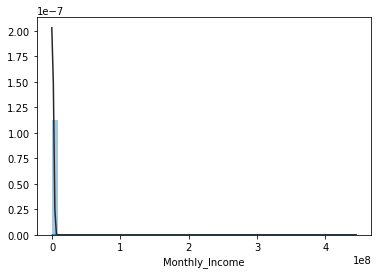

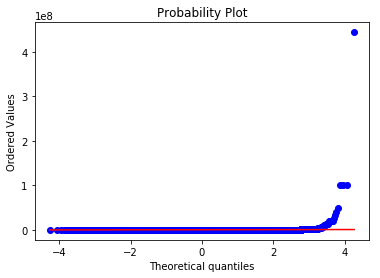

In [14]:
sns.distplot(X_train.Monthly_Income, fit=norm)
fig = plt.figure()
res = stats.probplot(X_train.Monthly_Income, plot=plt)

Widać już przy pierwszej zmiennej, tj. `Monthly_income`, źe outlier'y są na tyle odstające, że nie da się zwizualizować rozkładu, dlatego bardziej optymalne do zobrazowania danych będą `wykresy pudełkowe` - tym bardziej, że powyższe wykresy nie zadziałałyby dla zmiennych z brakami.

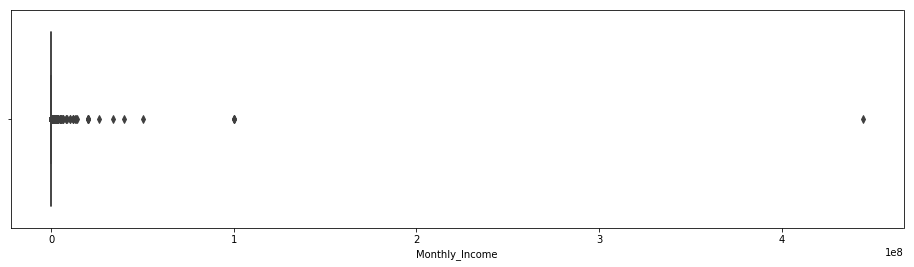

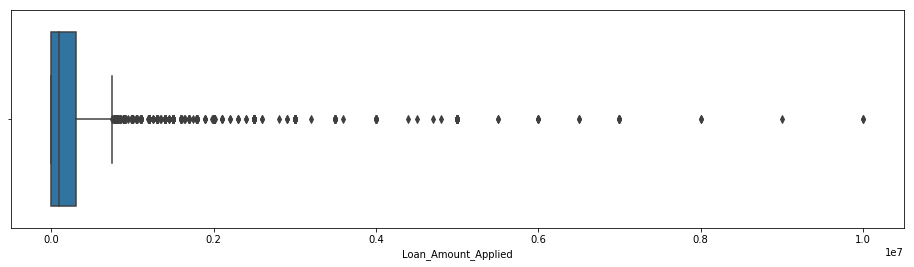

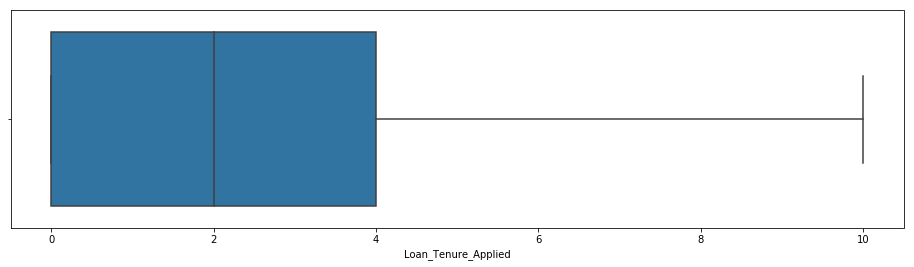

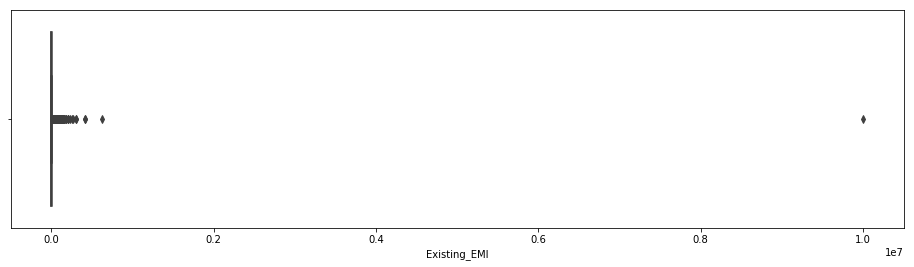

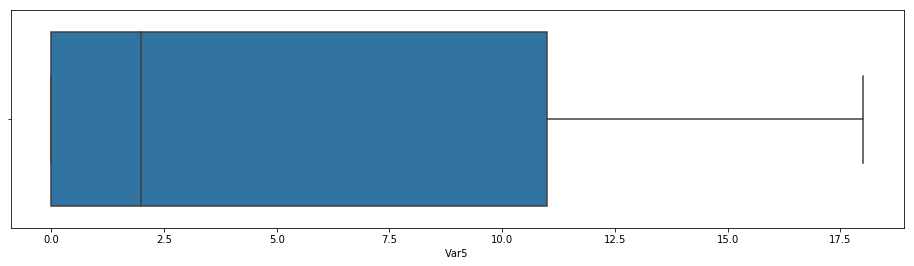

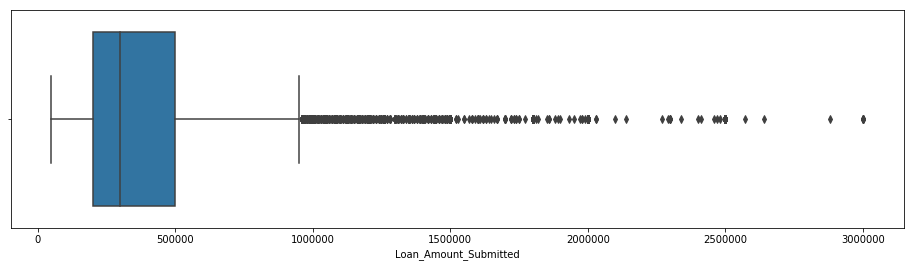

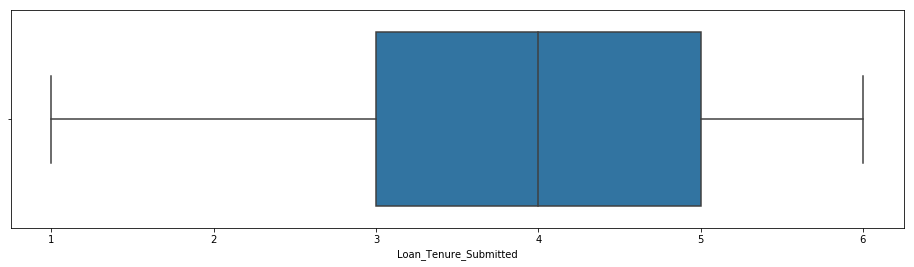

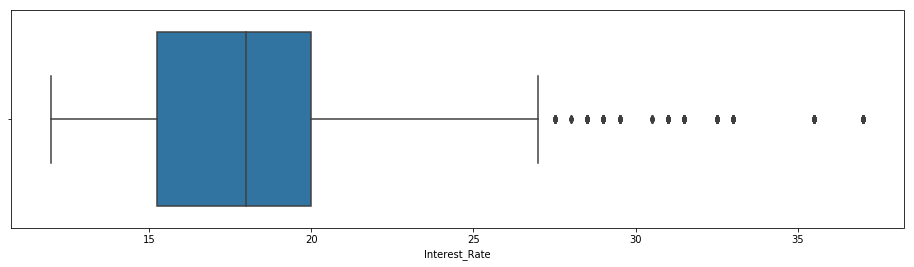

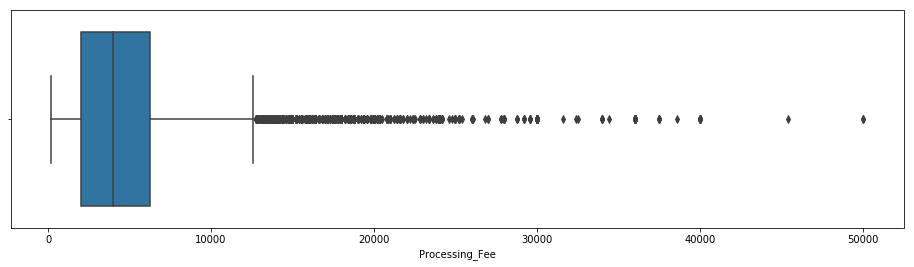

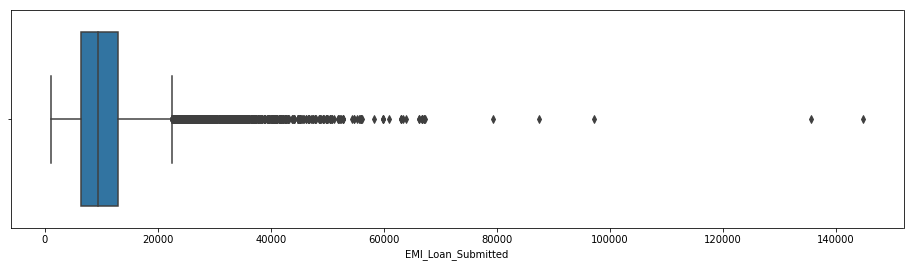

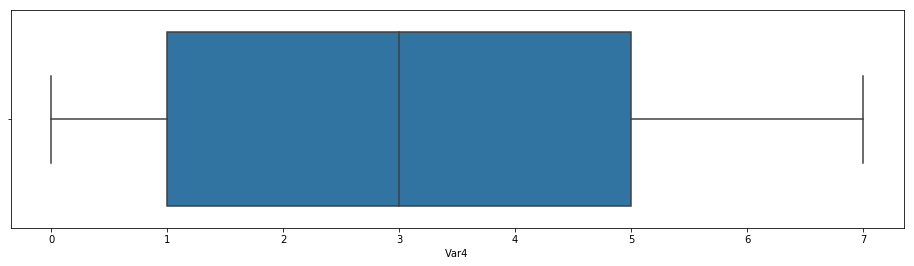

In [15]:
# sprawdzam, które zmienne mają dużo outlier'ów => trzeba je będzie obsłużyć również
for col in numerical_columns:
    fig, ax = plt.subplots(figsize=(14,3))
    sns.boxplot(X_train[col])
    plt.show()

Zmienne `Monthly_Income, Loan_Amount_Applied, Existing_EMI, Loan_Amount_Submitted, Interest_Rate, Processing_Fee, EMI_Loan_Submitted` mają bardzo dużo outlier'ów, dlatego zostają obsłużone odrębnie - samo zestandaryzowanie nie będzie wystarczające i optymalne z punktu widzenia modelowania.

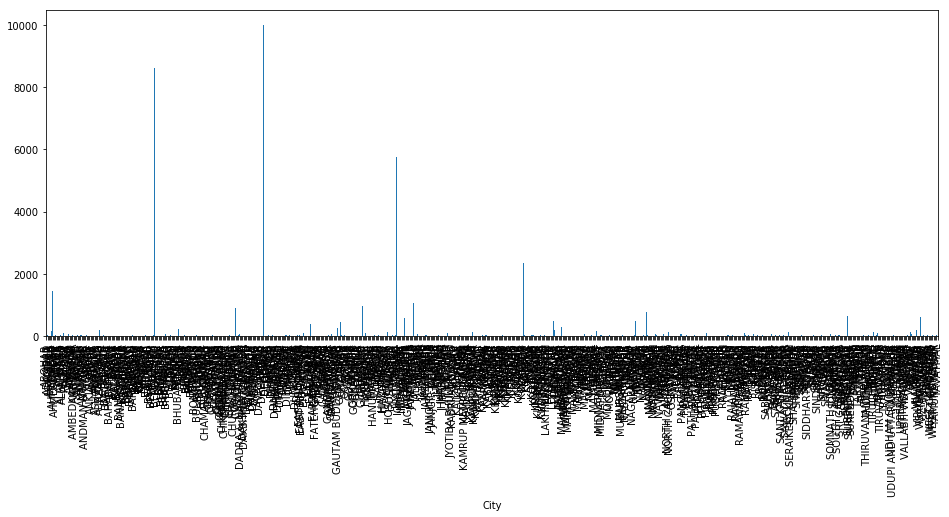

In [16]:
# rysuję wykres zliczający, ile jest obserwacji dla poszczególnych wartości unikalnych w zmiennej City
plt.subplots(figsize=(16,6))
a = X_train.groupby(['City'])['City'].count()
a.plot(kind='bar')
plt.show()

In [17]:
# Sortuję miasta wg kolejności - które wystpują najczęściej
df_cities = pd.DataFrame(X_train.City.value_counts())
df_cities.head(30)

,City
DELHI,9988
MUMBAI,8672
BENGALURU,8632
HYDERABAD,5747
CHENNAI,5555
PUNE,4209
KOLKATA,2344
AHMEDABAD,1444
JAIPUR,1067
GURGAON,973


Unikalnych wartości w zmiennej `City` jest niemal 700, a miasto na 30. miejscu wśród najczęściej występujących ma poniżej 0,5% udziału w zbiorze danych treningowych - w mojej ocenie można je potraktować jako grupy, a resztę miast o mniejszej liczbie występowań wrzucić do kategorii `others` -> następnie zostaną zmapowane na zmienną liczbową. 

In [19]:
# tworzę listę miast, które wystąpiły częściej niż dla 250 obserwacji -> będzie użyta do mapowania
often_cities_list = (df_cities[(df_cities['City'] > 250)].index)
np.size(often_cities_list), often_cities_list

(29, Index(['DELHI', 'MUMBAI', 'BENGALURU', 'HYDERABAD', 'CHENNAI', 'PUNE',
        'KOLKATA', 'AHMEDABAD', 'JAIPUR', 'GURGAON', 'COIMBATORE', 'NAN',
        'THANE', 'CHANDIGARH', 'SURAT', 'VISAKHAPATNAM', 'INDORE', 'VADODARA',
        'NAGPUR', 'LUCKNOW', 'GHAZIABAD', 'KOCHI', 'BHOPAL', 'FARIDABAD',
        'PATNA', 'MADURAI', 'NOIDA', 'GAUTAM BUDDHA NAGAR', 'DEHRADUN'],
       dtype='object'))

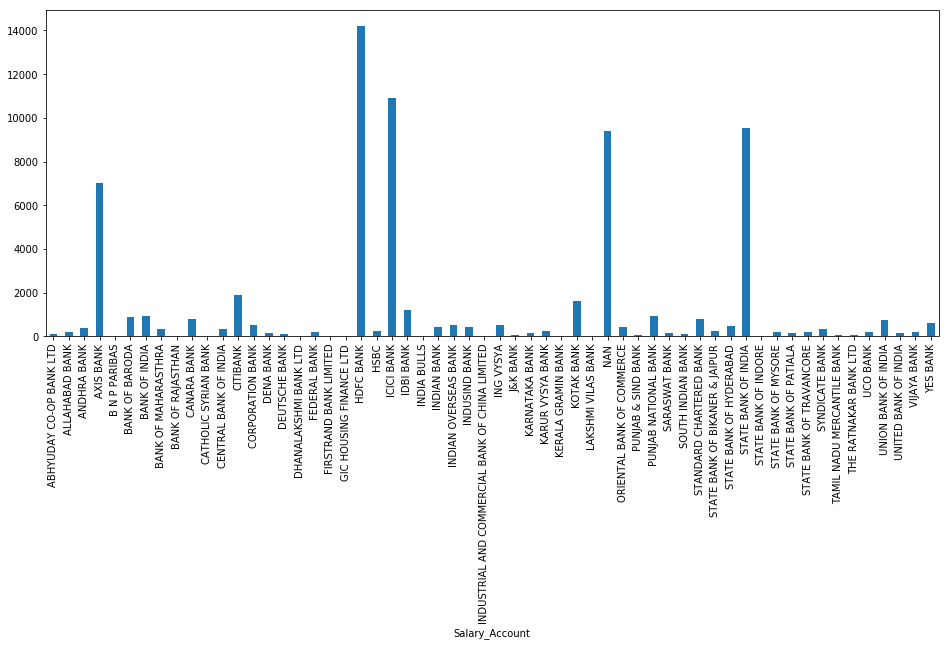

In [20]:
# rysuję analogiczny wykres dla zmiennej Salary_Account
plt.subplots(figsize=(16,6))
b = X_train.groupby(['Salary_Account'])['Salary_Account'].count()
b.plot(kind='bar')
plt.show()

In [21]:
# sortuję analogicznie Salary_Account w kolejności występowania
df_salary_accounts = pd.DataFrame(X_train.Salary_Account.value_counts())
df_salary_accounts.head(30)

,Salary_Account
HDFC BANK,14220
ICICI BANK,10906
STATE BANK OF INDIA,9521
NAN,9411
AXIS BANK,7037
CITIBANK,1905
KOTAK BANK,1629
IDBI BANK,1214
PUNJAB NATIONAL BANK,948
BANK OF INDIA,938


Można wysnuć podobne wnioski jak w przypadku zmiennej City. W przypadku zmiennej `Salary_Account` również mniej niż 10 zmiennych występuje ponad 1.000 razy, natomaist 30. pozycja na liście wystąpiła nieco ponad 200 razy.

In [22]:
# analogicznie tworzę listę najczęściej występujących kont bankowych -> do mapowania
often_banks_list = (df_salary_accounts[(df_salary_accounts['Salary_Account'] > 250)].index)
np.size(often_banks_list), often_banks_list

(29,
 Index(['HDFC BANK', 'ICICI BANK', 'STATE BANK OF INDIA', 'NAN', 'AXIS BANK',
        'CITIBANK', 'KOTAK BANK', 'IDBI BANK', 'PUNJAB NATIONAL BANK',
        'BANK OF INDIA', 'BANK OF BARODA', 'CANARA BANK',
        'STANDARD CHARTERED BANK', 'UNION BANK OF INDIA', 'YES BANK',
        'ING VYSYA', 'CORPORATION BANK', 'INDIAN OVERSEAS BANK',
        'STATE BANK OF HYDERABAD', 'INDIAN BANK', 'ORIENTAL BANK OF COMMERCE',
        'INDUSIND BANK', 'ANDHRA BANK', 'CENTRAL BANK OF INDIA',
        'SYNDICATE BANK', 'BANK OF MAHARASTHRA', 'HSBC',
        'STATE BANK OF BIKANER & JAIPUR', 'KARUR VYSYA BANK'],
       dtype='object'))

Zmienna `Salary_account` ma 57 unikalnych wartości, z czego 2 mają ponad 10.000 obserwacji, następnie kilka ponad 1.000 obserwacji.

In [23]:
# Analogicznie zliczam unikalne wartości dla zmiennej 'Employer_Name'
c = X_train.groupby(['Employer_Name'])['Employer_Name'].count()

In [24]:
# Sortuję analogicznie w kolejności występowania
c.sort_values(axis=0, ascending=False)

Employer_Name
0                                                 3949
TATA CONSULTANCY SERVICES LTD (TCS)                448
COGNIZANT TECHNOLOGY SOLUTIONS INDIA PVT LTD       329
ACCENTURE SERVICES PVT LTD                         251
GOOGLE                                             232
HCL TECHNOLOGIES LTD                               205
ICICI BANK LTD                                     194
INDIAN AIR FORCE                                   148
INFOSYS TECHNOLOGIES                               143
GENPACT                                            141
IBM CORPORATION                                    139
INDIAN ARMY                                        139
TYPE SLOWLY FOR AUTO FILL                          129
WIPRO TECHNOLOGIES                                 123
HDFC BANK LTD                                      117
IKYA HUMAN CAPITAL SOLUTIONS LTD                   102
STATE GOVERNMENT                                   101
INDIAN NAVY                                        

Zmienna `Employer_Name` ma ponad 35.000 unikalnych wartości, więc rysowanie wykresu nie ma sensu, ponieważ były zupełnie nieczytelny (zresztą kernel się zawiesza). Jest 16 pracodawców, dla których było ponad 100 obserwacji, ale okazuje się, że jest spory "bałagan" na liście pracodawców, tj. na pierwszym miejscu wyskoczyło zero - należałoby to traktować jako brak danych, a poza tym widać, że mamy na liście różne spółki należące do tej samej grupy, czyli pierwszy człon wspólny, ale dalsza część nazwy się różni - w mojej ocenie zmienna nie jest istotna, a jej sensowne wyczyszczenie wymagałoby bardzo dużo pracy, więc należy ją **usunąć**.

In [25]:
# obsługa outlier'ów - w pierwszej kolejności wypiszę rozkłądy ćwiartkowe i podstawowe statystyki
outliers = ['Monthly_Income', 'Loan_Amount_Applied', 'Existing_EMI', 'Loan_Amount_Submitted', 
            'Interest_Rate', 'Processing_Fee', 'EMI_Loan_Submitted']
Q1 = X_train.quantile(0.25)
Q3 = X_train.quantile(0.75)
IQR = Q3 - Q1
IQR[outliers]

Monthly_Income           23500.00
Loan_Amount_Applied     300000.00
Existing_EMI              3500.00
Loan_Amount_Submitted   300000.00
Interest_Rate                4.75
Processing_Fee            4250.00
EMI_Loan_Submitted        6444.04
dtype: float64

In [26]:
mins = np.min(X_train) # minimalne wartości zmiennych
maxs = np.max(X_train) # maksymalne -||-
left = Q1 - 1.5 * IQR # wyliczam lewy brzeg zakresu, który należy uznać za normalny dla zmiennych
right = Q3 + 1.5 * IQR # analogicznie wyliczam prawy brzeg
std = np.std(X_train) # odchylenie standardowe

In [27]:
# wyświetlam powyższe wyliczenia dla zmiennych z outlier'ami
pd.DataFrame({'Q1': Q1[outliers], 'Q3': Q3[outliers], 'IQR': IQR[outliers], 
              'min': mins[outliers], 'max': maxs[outliers], 'std': std[outliers], 
              'left (Q1 - 1.5x IQR)': left[outliers], 'right (Q3 + 1.5x IQR)': right[outliers]})

,Q1,Q3,IQR,min,max,std,left (Q1 - 1.5x IQR),right (Q3 + 1.5x IQR)
Monthly_Income,16500.00,40000.00,23500.00,0,444554443,1846989.12,-18750.00,75250.00
Loan_Amount_Applied,0.00,300000.00,300000.00,0.00,10000000.00,355477.50,-450000.00,750000.00
Existing_EMI,0.00,3500.00,3500.00,0.00,10000000.00,39163.29,-5250.00,8750.00
Loan_Amount_Submitted,200000.00,500000.00,300000.00,50000.00,3000000.00,307564.18,-250000.00,950000.00
Interest_Rate,15.25,20.00,4.75,11.99,37.00,5.84,8.12,27.12
Processing_Fee,2000.00,6250.00,4250.00,200.00,50000.00,4699.72,-4375.00,12625.00
EMI_Loan_Submitted,6491.83,12935.87,6444.04,1176.41,144748.28,7483.74,-3174.23,22601.93


Komentarz / wniosek: dla zmiennych, dla których lewy brzeg wypadł poniżej zera, to przypiszemy zero, a zredukujemy jedynie wartości przekraczające prawy próg (z lewej strony należy obsłużyć jedynie jedną zmienną, tj. Interest_Rate).

In [28]:
# tworzę granice "normalności", które przyjmę dla zmiennych odstających
right_MonInc = right['Monthly_Income']
right_LoanAmtApp = right['Loan_Amount_Applied']
right_ExEMI = right['Existing_EMI']
right_LoanAmtSub = right['Loan_Amount_Submitted']
right_IntRate = right['Interest_Rate']
left_IntRate = left['Interest_Rate']
right_ProcFee = right['Processing_Fee']
right_EMISub = right['EMI_Loan_Submitted']

Poniżej tworzę funkcję `transform1`, która dokona dalszej obróbki danych na podstawie powyższych ustaleń, tj.:
- zmapuje zmienne `City` i `Salary_Account` wg najczęśćiej występujących wartości,
- uzupełnia zerami braki zmiennych nieodstających, tj. opisujące wnioskowane i przyznane okresy kredytowania,
- sprowadza do "normalności" zmienne odstąjące.

Najpierw twórzę grupy do mapowania zmiennych kategorycznych - analogicznie jak wyżej przed wstępną transformacją.

In [29]:
# grupy do zmapowania pozostałych zmiennych kategorycznych na numeryczne wg wcześniej ustalonej listy unikatów
city_schema = get_groups(get_unique_values(often_cities_list))
city_schema['OTHERS'] = 30
salary_schema = get_groups(get_unique_values(often_banks_list))
salary_schema['OTHERS'] = 30

In [30]:
def transform1(df: pd.DataFrame) -> pd.DataFrame:
    df.City = df.City.apply(lambda x: x if x in often_cities_list else 'OTHERS')
    df['City'].replace(city_schema, inplace=True)

    df.Salary_Account = df.Salary_Account.apply(lambda x: x if x in often_banks_list else 'OTHERS')
    df['Salary_Account'].replace(salary_schema, inplace=True)
    
    df.Interest_Rate.fillna(0, inplace=True) # zmienna jest obsługiwana poniżej, ale uzupełnienie 0 nie działało
    df.Loan_Tenure_Applied.fillna(0, inplace=True)
    df.Loan_Tenure_Submitted.fillna(0, inplace=True)

    df.Monthly_Income = df.Monthly_Income.apply(
        lambda x: 0 if x == np.nan else x if x < right_MonInc else right_MonInc)
    df.Loan_Amount_Applied = df.Loan_Amount_Applied.apply(
        lambda x: 0 if x == np.nan else x if x < right_LoanAmtApp else right_LoanAmtApp)
    df.Existing_EMI = df.Existing_EMI.apply(
        lambda x: 0 if x == np.nan else x if x < right_ExEMI else right_ExEMI)
    df.Loan_Amount_Submitted = df.Loan_Amount_Submitted.apply(
        lambda x: 0 if x == np.nan else x if x < right_LoanAmtSub else right_LoanAmtSub)
    df.Interest_Rate = df.Interest_Rate.apply(
        lambda x: right_IntRate if x > right_IntRate else left_IntRate if x < left_IntRate else x)
    df.Processing_Fee = df.Processing_Fee.apply(
        lambda x: 0 if x == np.nan else x if x < right_ProcFee else right_ProcFee)
    df.EMI_Loan_Submitted = df.EMI_Loan_Submitted.apply(
        lambda x: 0 if x == np.nan else x if x < right_EMISub else right_EMISub)
    
    df.drop(['Employer_Name'], axis=1, inplace=True)

    return df

In [31]:
# dokonuję finalnej transformacji danych
transform1(X_train)
print_df_description(X_train)

,Column_names,Column_types,Num_of_NaN,NaN_%,Num_of_zeros,Zeros_%,Unique_val_amt,Unique_values
0,Gender,int64,0,0.00,29606,42.53,2,"[0, 1]"
1,City,int64,0,0.00,1444,2.07,30,"[0, 1, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,..."
2,Monthly_Income,float64,0,0.00,244,0.35,4508,"[0.0, 1.0, 10.0, 100.0, 1000.0, 10000.0, 10022..."
3,DOB,int64,0,0.00,0,0.00,59,"[104, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, ..."
4,Lead_Creation_Date,int64,0,0.00,0,0.00,3,"[5, 6, 7]"
5,Loan_Amount_Applied,float64,0,0.00,23019,33.07,175,"[0.0, 100.0, 1000.0, 10000.0, 100000.0, 101000..."
6,Loan_Tenure_Applied,float64,0,0.00,27083,38.90,10,"[0.0, 1.0, 10.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0,..."
7,Existing_EMI,float64,0,0.00,46500,66.79,1919,"[0.0, 1.0, 1.5, 10.0, 100.0, 1000.0, 1004.0, 1..."
8,Salary_Account,int64,0,0.00,393,0.56,30,"[0, 1, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,..."
9,Mobile_Verified,int64,0,0.00,24340,34.96,2,"[0, 1]"


**Dane nie zawierają już żadnych braków i wszystkie zostały zamienione na zmienne numeryczne.** Możemy przystąpić do modelowania, przy czym najpierw trzeba dokonać **analogicznej transformacji danych tetstowych**.
<font color='red'>**Pozostaje jeszcze kwestia niezbalansowania danych.**</font>

In [32]:
transform(X_test)
transform1(X_test)
print_df_description(X_test)

,Column_names,Column_types,Num_of_NaN,NaN_%,Num_of_zeros,Zeros_%,Unique_val_amt,Unique_values
0,Gender,int64,0,0.00,7566,43.47,2,"[0, 1]"
1,City,int64,0,0.00,344,1.98,30,"[0, 1, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,..."
2,Monthly_Income,float64,0,0.00,70,0.40,1691,"[0.0, 1.0, 10.0, 1000.0, 10000.0, 10002.0, 100..."
3,DOB,int64,0,0.00,0,0.00,55,"[104, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, ..."
4,Lead_Creation_Date,int64,0,0.00,0,0.00,3,"[5, 6, 7]"
5,Loan_Amount_Applied,float64,0,0.00,5834,33.52,100,"[0.0, 10.0, 10000.0, 100000.0, 109000.0, 11000..."
6,Loan_Tenure_Applied,float64,0,0.00,6832,39.26,9,"[0.0, 1.0, 10.0, 2.0, 3.0, 4.0, 5.0, 7.0, 8.0]"
7,Existing_EMI,float64,0,0.00,11738,67.44,741,"[0.0, 1.0, 10.0, 100.0, 1000.0, 1020.0, 1025.0..."
8,Salary_Account,int64,0,0.00,92,0.53,30,"[0, 1, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,..."
9,Mobile_Verified,int64,0,0.00,6199,35.62,2,"[0, 1]"


Ponadto sprawdzam korelację danych - poniżej widać, że niektóre zmienne są bardzo mocno skorelowane, potwierdza się też moje wcześniejsze założenie, że niewyjaśnione zmienne `Var` mogą agregować informacje z innych zmiennych, ale nie mamy pewności, czy wszystkie zmienne w dostępnych danych pochodzą z wniosków, czy są agregacją kilku zmiennych wprowadzanych przez klientów. Można najpierw zrobić modele na wszystkich zmiennych, a następnie sprawdzić, czy usunięcie skorelowanych zmiennych nie da lepszego wyniku.

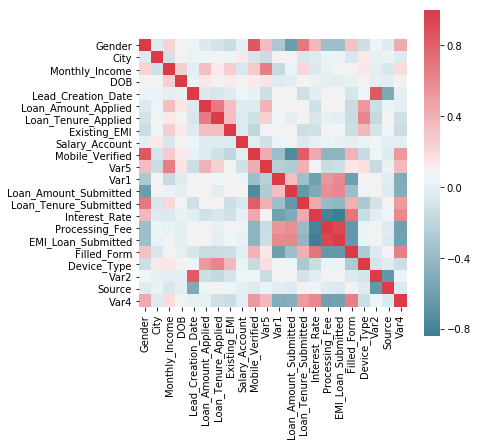

In [34]:
f, ax = plt.subplots(figsize=(6,6))
corr1 = X_train.corr()
sns.heatmap(corr1, mask=np.zeros_like(corr1, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

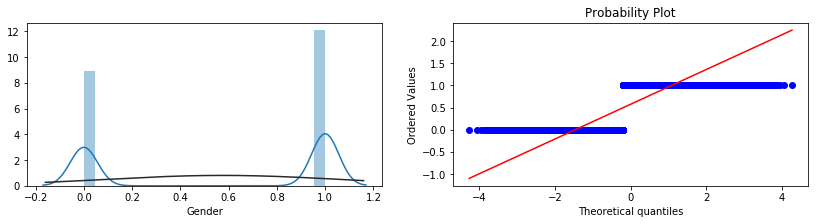

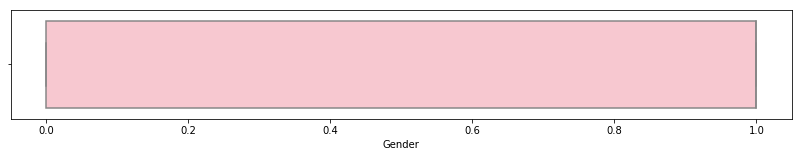

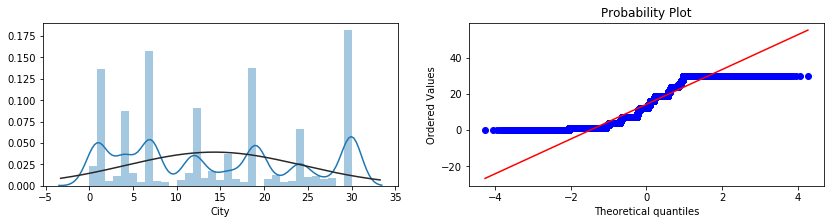

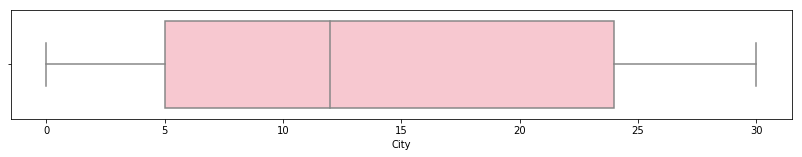

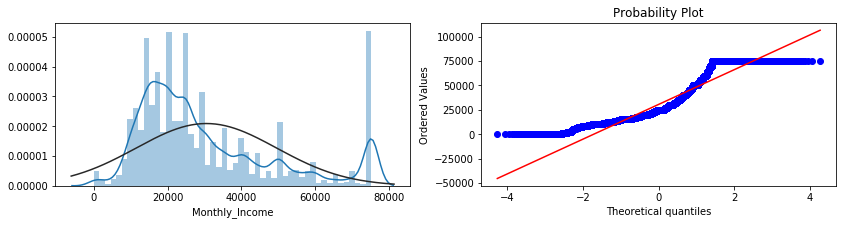

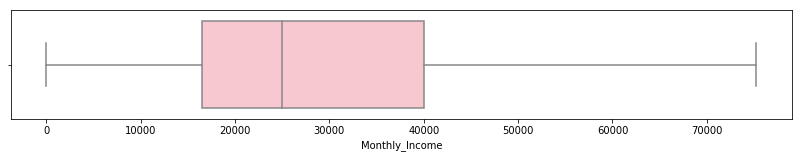

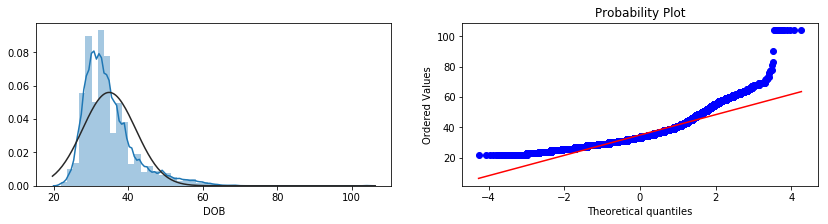

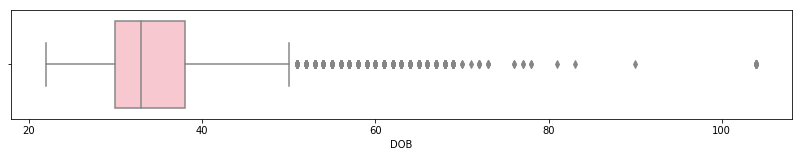

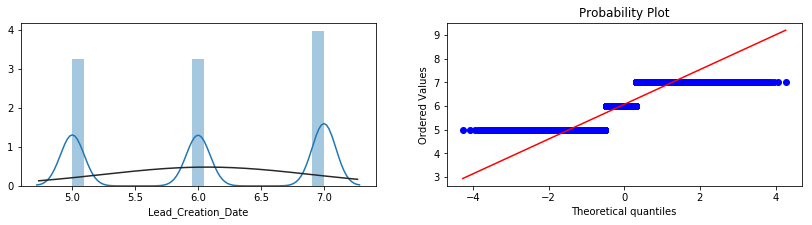

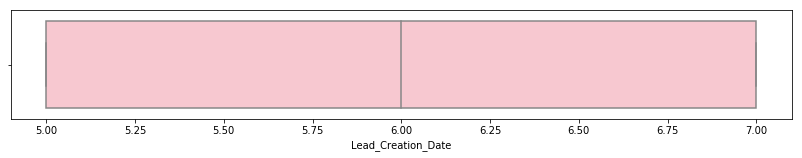

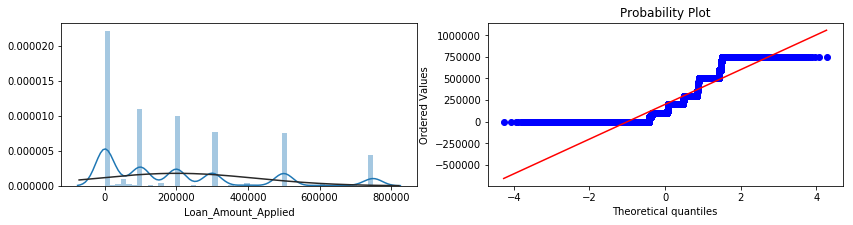

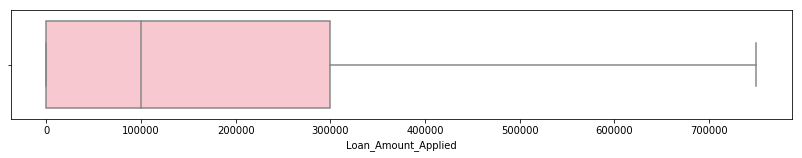

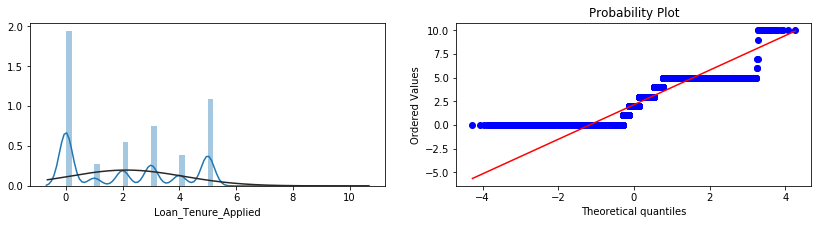

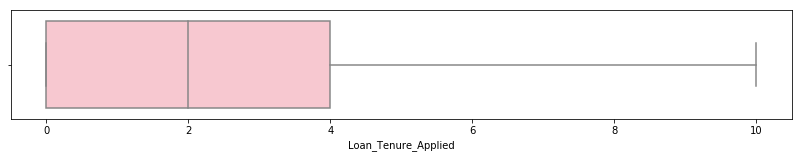

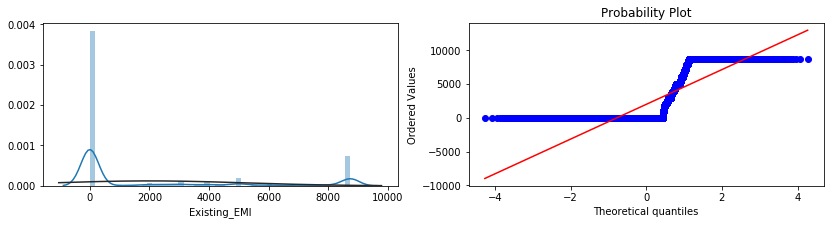

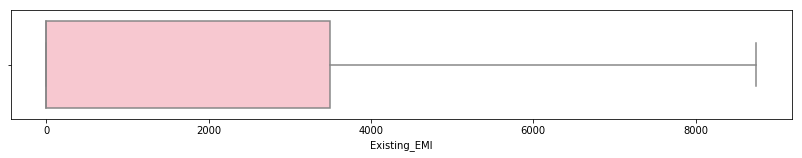

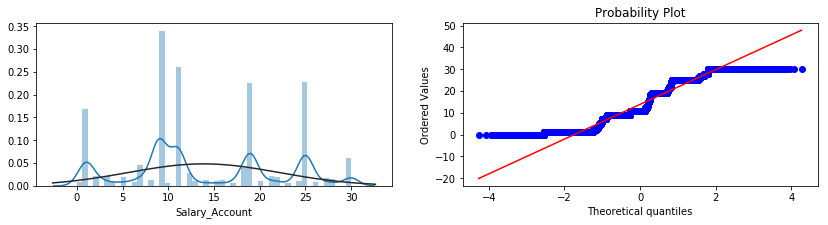

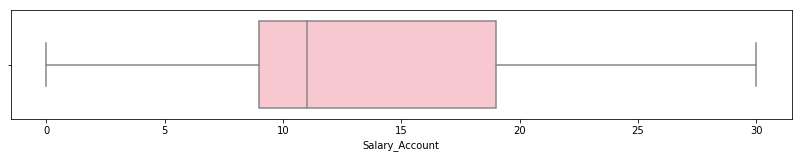

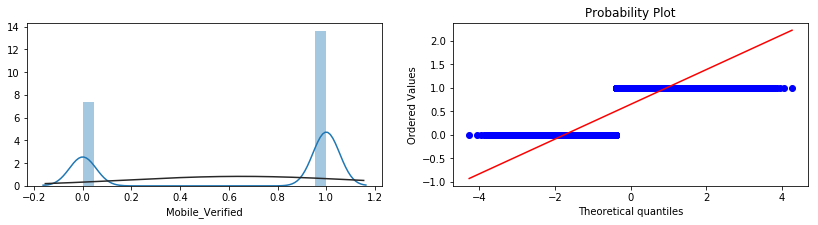

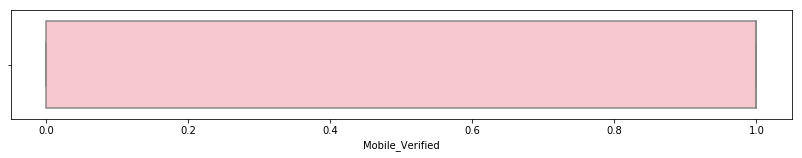

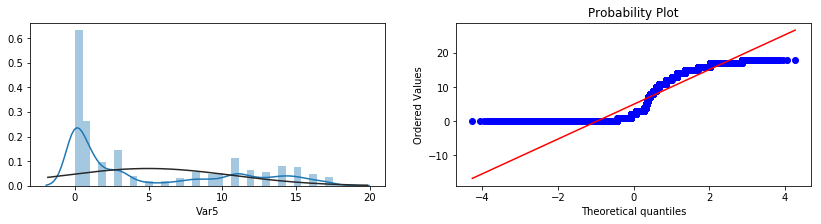

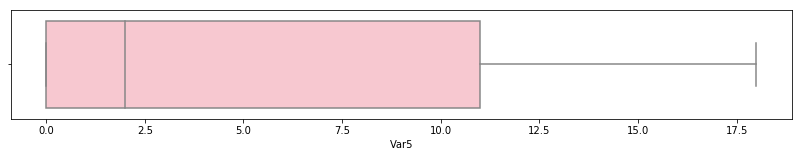

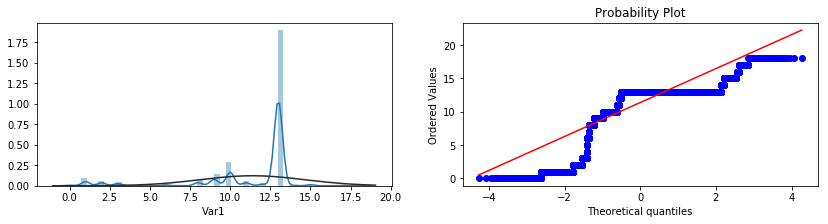

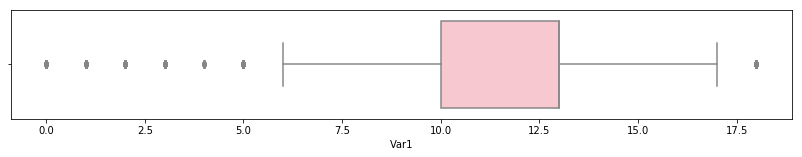

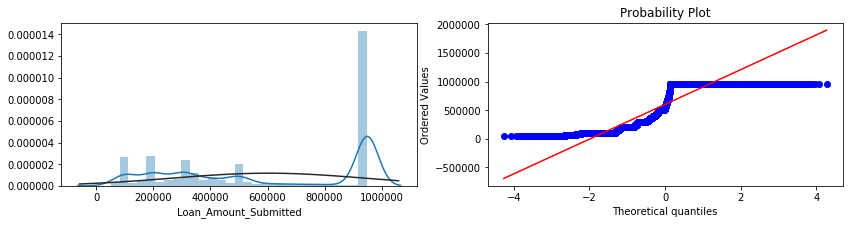

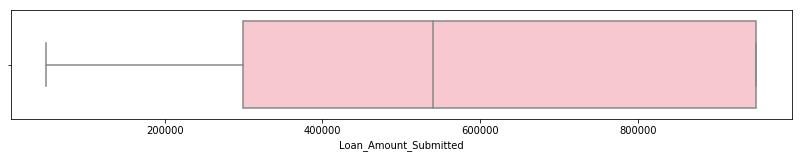

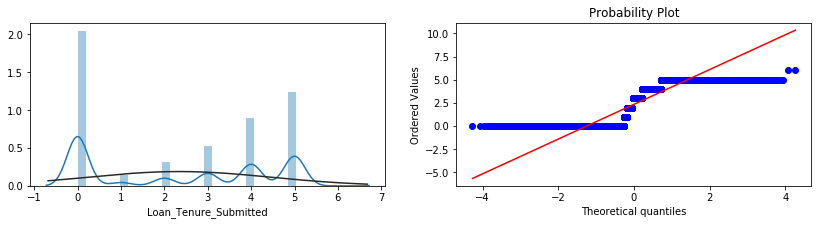

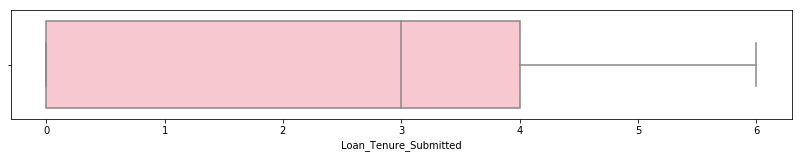

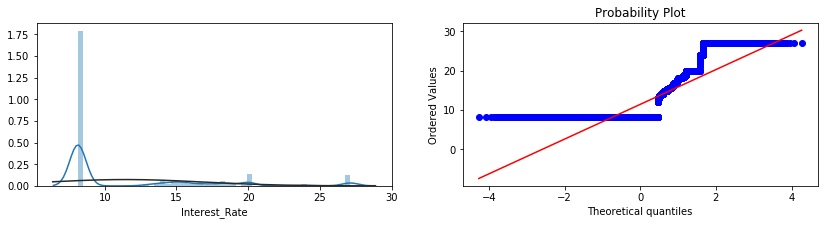

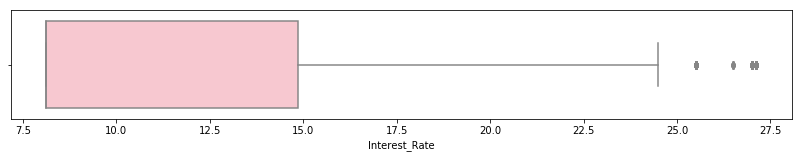

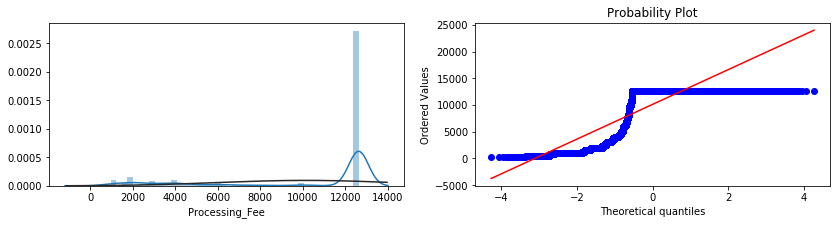

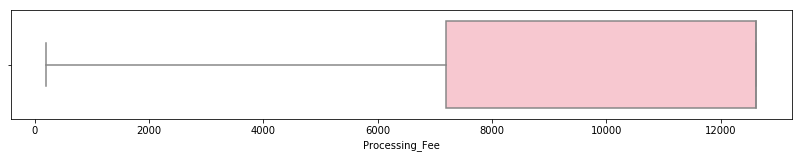

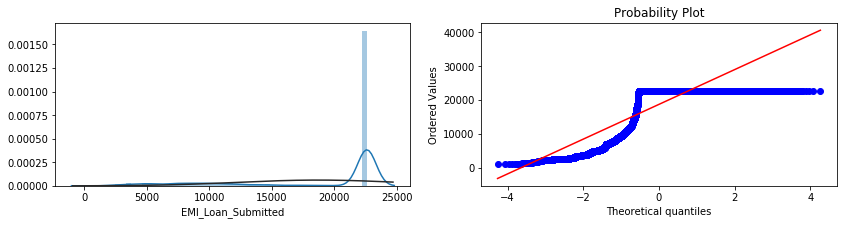

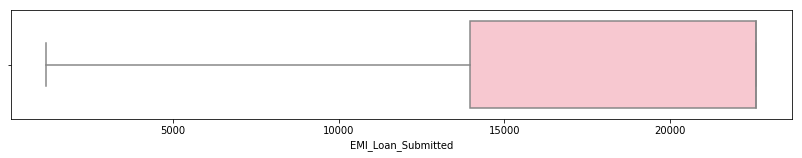

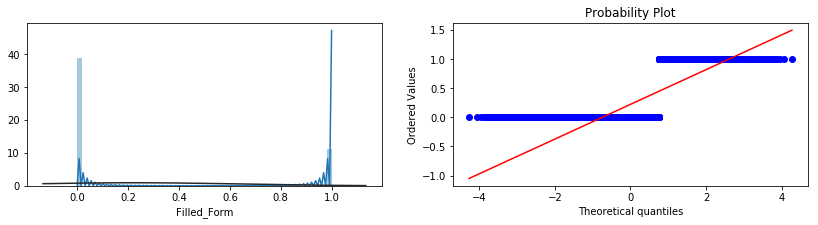

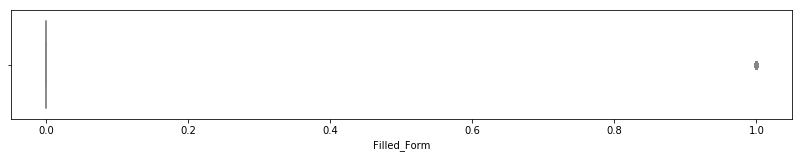

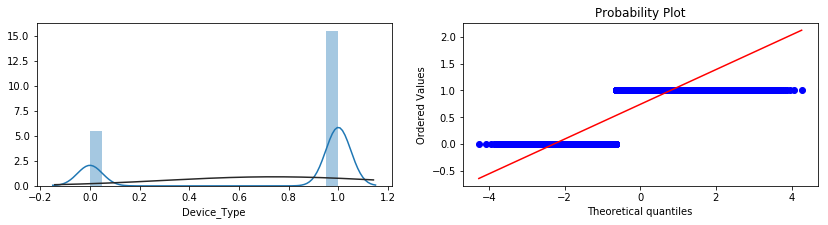

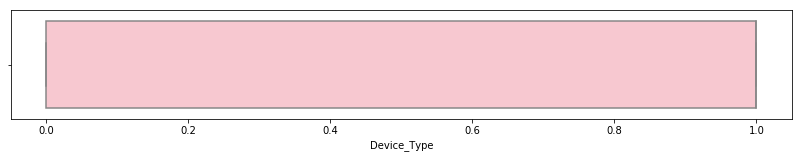

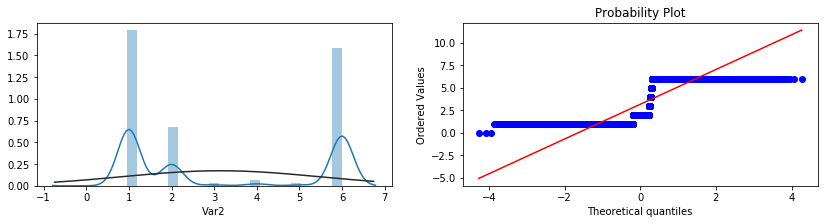

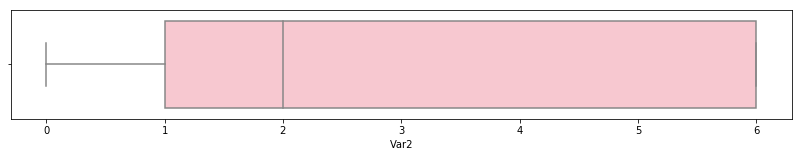

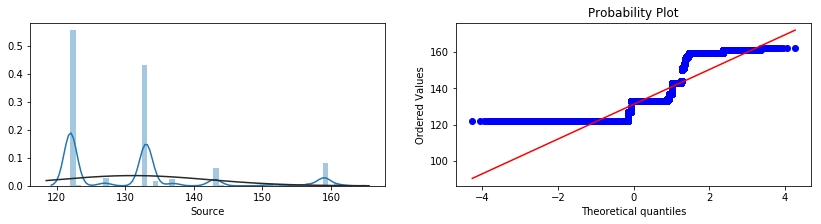

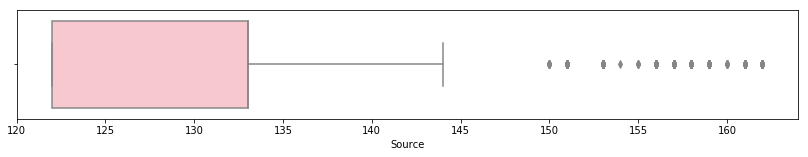

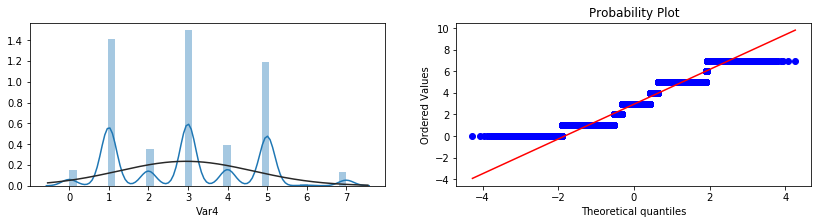

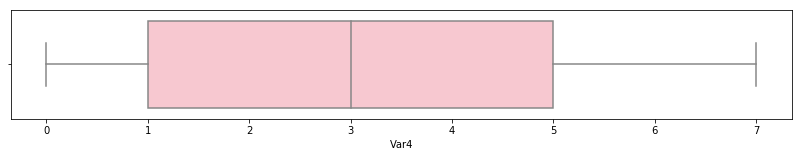

In [35]:
# wizualizuję rozkłady zmiennych po finalnych transformacjach
columns = X_train.columns
for column in columns:    
    plt.figure(figsize=(14,3))
    plt.subplot(121)
    sns.distplot(X_train[column], fit=norm)
    # fig = plt.figure()
    plt.subplot(122)
    res = stats.probplot(X_train[column], plot=plt)
    fig, ax = plt.subplots(figsize=(14,2))
    sns.boxplot(X_train[column], color='pink')

In [36]:
np.unique(X_train.Filled_Form)

array([0, 1])

<font color='red'>Nie rozumiem, dlaczego zmienna `Filled_Form` wyświetla się w taki sposób, ponieważ ma tylko dwie unikalne wartości [0, 1] podobnie jak np. Gender.</font>

# Modelowanie

In [39]:
# puszczam zwykły model regresji logistycznej bez żadnych parametrów
model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
np.unique(y_pred)

array([0])

In [40]:
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_true=y_test, y_pred=y_pred)
auc = roc_auc_score(y_true=y_test, y_score=model.predict_proba(X_test)[:,1])
dop = accuracy_score(model.predict(X_train), y_train)
print(f'Accuracy: {acc} || F1: {f1} || AUC: {auc}')
if acc > dop:
    print(f'Jakość predykcji > dopasowanie ze zb. treningowym ({dop})')
else:
    print(f'Jakość predykcji < dopasowanie ze zb. treningowym ({dop})')

Accuracy: 0.9853481958170536 || F1: 0.0 || AUC: 0.7707892416981954
Jakość predykcji < dopasowanie ze zb. treningowym (0.9853769248448633)


In [41]:
# robię prostą funkcję, dzięki której "na szybko" przetestuję analogicznie wyniki dla różnych klasyfikatorów
def simple_model(model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(np.unique(y_pred))
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_true=y_test, y_pred=y_pred)
    auc = roc_auc_score(y_true=y_test, y_score=model.predict_proba(X_test)[:,1])
    dop = accuracy_score(model.predict(X_train), y_train)
    x = f'Accuracy: {acc} || F1: {f1} || AUC: {auc}'
    if acc > dop:
        y = f'Jakość predykcji > dopasowanie ze zb. treningowym ({dop})'
    else:
        y = f'Jakość predykcji < dopasowanie ze zb. treningowym ({dop})'
    return x, y

In [44]:
model1a = LogisticRegression(class_weight={0: 0.5, 1: 10})
simple_model(model1a)

[0 1]


('Accuracy: 0.9192139737991266 || F1: 0.11237373737373739 || AUC: 0.8257714678384036',
 'Jakość predykcji > dopasowanie ze zb. treningowym (0.9182946449092163)')

In [58]:
model1b = make_pipeline(StandardScaler(), LogisticRegression(class_weight={0: 0.5, 1: 10}))
simple_model(model1b)

[0 1]


('Accuracy: 0.91984601241094 || F1: 0.1176470588235294 || AUC: 0.8330397130570697',
 'Jakość predykcji > dopasowanie ze zb. treningowym (0.9184813835899793)')

**Widać, że "czysta" regresja logistyczna działa bardzo dobrze - samo dodanie wag poprawia predykcję, a poprzedzenie standaryzacją jeszcze bardziej - można będzie "pobawić się" wagami i parametrami.**

In [62]:
model2a = XGBClassifier(max_depth=50, n_estimators=50, class_weight={0: 0.5, 1: 10})
simple_model(model2a)

[0 1]


('Accuracy: 0.9852332797058148 || F1: 0.007722007722007722 || AUC: 0.8285154682317268',
 'Jakość predykcji < dopasowanie ze zb. treningowym (0.9931481268673868)')

In [63]:
model2b = XGBClassifier(max_depth=50, n_estimators=50)
simple_model(model2b)

[0 1]


('Accuracy: 0.9852332797058148 || F1: 0.007722007722007722 || AUC: 0.8285154682317268',
 'Jakość predykcji < dopasowanie ze zb. treningowym (0.9931481268673868)')

**Okazuę się, że w przypadku XGBoost'a nie działa parametr `class_weight`, bo bez jego zastosowania wychodzi identyczny wynik - można zatem zastosować `oversampling` albo wrzucić wagi do GridSearch'a w dalszych krokach. Widać, że bez tego predykcja wychodzi bardzo niska.**

In [64]:
model3a = RandomForestClassifier(max_depth=20, min_samples_leaf=400)
simple_model(model3a)

[0]


('Accuracy: 0.9853481958170536 || F1: 0.0 || AUC: 0.8484056121719783',
 'Jakość predykcji < dopasowanie ze zb. treningowym (0.9853769248448633)')

In [70]:
model3b = RandomForestClassifier(max_depth=20, min_samples_leaf=400, class_weight={0: 0.5, 1: 10})
simple_model(model3b)

[0 1]


('Accuracy: 0.9494369110549299 || F1: 0.15384615384615388 || AUC: 0.8434251582725341',
 'Jakość predykcji > dopasowanie ze zb. treningowym (0.948287749942542)')

In [71]:
model3c = RandomForestClassifier(max_depth=100, min_samples_leaf=100, class_weight={0: 0.5, 1: 10})
simple_model(model3c)

[0 1]


('Accuracy: 0.9539760974488624 || F1: 0.1414790996784566 || AUC: 0.8442853239027257',
 'Jakość predykcji < dopasowanie ze zb. treningowym (0.9542346586991496)')

In [72]:
model3d = RandomForestClassifier(max_depth=100, min_samples_leaf=100, class_weight={0: 0.5, 1: 25})
simple_model(model3d)

[0 1]


('Accuracy: 0.8426798437140887 || F1: 0.10288335517693314 || AUC: 0.8431842478667366',
 'Jakość predykcji > dopasowanie ze zb. treningowym (0.8415594116295104)')

**RCF radzi sobie całkiem nieźle - trzeba jeszcze znależć optymalne parametry.**

In [73]:
# tworzę klasę do selekcji zmiennych wg nazw
class ColumnSelectorByName(TransformerMixin, BaseEstimator):
    
    def __init__(self, columns):
        self.columns = columns
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X[self.columns]

# wypisuję listy zmiennych, które oryginalnie były kategoryczne i użyję na nich 
# OneHotEncoder'a, a także zmienne numeryczne, które zestandaryzuję
originally_categorical_features = [
    'Gender', 'City', 'DOB', 'Lead_Creation_Date', 'Salary_Account', 'Mobile_Verified', 
    'Var1', 'Filled_Form', 'Device_Type', 'Var2', 'Source']
numerical_features = [
    'Monthly_Income', 'Loan_Amount_Applied', 'Loan_Tenure_Applied', 
    'Existing_EMI', 'Var5', 'Loan_Amount_Submitted', 'Loan_Tenure_Submitted', 
    'Interest_Rate', 'Processing_Fee', 'EMI_Loan_Submitted', 'Var4']
    
# tworzę pipeline'y, które użyję do transformatora
categorical_pipeline = Pipeline([
    ('selector', ColumnSelectorByName(originally_categorical_features)),
    ('onehot', OneHotEncoder(sparse=False, handle_unknown='ignore')),
])

numeric_pipeline = Pipeline([
    ('selector', ColumnSelectorByName(numerical_features)),
    ('scaler', StandardScaler()),
])

# transformator - preprocessor, który agreguje powyższe pipeline'y
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_pipeline, numerical_features),
        ('cat', categorical_pipeline, originally_categorical_features),
    ]
)

In [74]:
# wyliczam klasy za pomocą compute_class_weight
class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)
class_weights = {0: class_weights[0], 1: class_weights[1]}
class_weights

{0: 0.5074200414006239, 1: 34.19253438113949}

Dla jedynek wyszła wyższa waga niż założyłam - sprawdzę, czy daje lepsze wyniki.

In [75]:
model1c = make_pipeline(preprocessor, LogisticRegression(class_weight={0: 0.5, 1: 10}))
simple_model(model1c)

[0 1]


('Accuracy: 0.9184670190760744 || F1: 0.1331704337202199 || AUC: 0.8476290277029817',
 'Jakość predykcji > dopasowanie ze zb. treningowym (0.9146316938634796)')

**Z moim preprocessorem wychodzi nieco gorsze acc, ale lepsze F1. Sprawdzę jeszcze dla wyliczonych klas.**

In [76]:
model1d = make_pipeline(preprocessor, LogisticRegression(class_weight=class_weights))
simple_model(model1d)

[0 1]


('Accuracy: 0.768041829464491 || F1: 0.08685817688305814 || AUC: 0.8453017897344954',
 'Jakość predykcji > dopasowanie ze zb. treningowym (0.7585612502872903)')

In [77]:
model1e = make_pipeline(preprocessor, PCA(), LogisticRegression(class_weight={0: 0.5, 1: 10}))
simple_model(model1e)

[0 1]


('Accuracy: 0.9184095610204551 || F1: 0.1330891330891331 || AUC: 0.847635430637355',
 'Jakość predykcji > dopasowanie ze zb. treningowym (0.9146316938634796)')

**Wynik znacznie się pogarsza, czyli te klasy nie są optymalne - sprawdzę jeszcze na przykładzie innego modelu. Redukcja wymiaru przy użyciu PCA nieznacznie pogorszyła wynik.**

In [78]:
model2c = make_pipeline(preprocessor, XGBClassifier(max_depth=100, n_estimators=25))
simple_model(model2c)

[0 1]


('Accuracy: 0.9852907377614342 || F1: 0.0 || AUC: 0.8363897054535852',
 'Jakość predykcji < dopasowanie ze zb. treningowym (0.9868708342909676)')

**Użycie preprocessora pogarsza wynik XGB -> trzeba sprawdzić jak będzie się zachowywał z wagami.**

In [81]:
model3e = make_pipeline(preprocessor, RandomForestClassifier(
    max_depth=100, min_samples_leaf=100, class_weight={0: 0.5, 1: 10}))
simple_model(model3e)

[0 1]


('Accuracy: 0.9630544702367272 || F1: 0.14834437086092717 || AUC: 0.8419356756639328',
 'Jakość predykcji > dopasowanie ze zb. treningowym (0.9622644219719605)')

**Dodanie preprocessora daje nieco lepszy wynik.**

**Rozpoczynam szukanie najlepszych parametrów dla poszczególnych modeli przy użyciu `GridSerachCV` - ponieważ dane są bardzo duże i wymagają dużej mocy obliczeniowej, będę tworzyć odrębne GS dla poszczególnych modeli, a następnie stworzę zagregowany dla najlepszych parametrów, który mógłby być wykorzystany do przeliczenia, ale optymalizuję ze względu na czas obliczeń.**

In [143]:
# tworzę GridSearch do szukania najlepszych parametrów dla regresji logistycznej (na razie podstawowej)
pipe_1 = Pipeline([
    ('LR', LogisticRegression()),
])

param_grid_1 = {
    'LR__penalty': ['l1', 'l2'],
    'LR__tol': [0.001, 0.01],
    'LR__C': [0.001, 0.1, 1],
    'LR__class_weight': [{0: 0.5, 1: 10}, {0: 0.5, 1: 5}],
}

grid_1 = GridSearchCV(
    estimator=pipe_1,
    param_grid=param_grid_1,
    cv=3,
    n_jobs=-1, 
    refit=True, # defaultowy parametr (można usunąć)
    return_train_score=True,
)

grid_1.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('LR', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'LR__penalty': ['l1', 'l2'], 'LR__tol': [0.001, 0.01], 'LR__C': [0.001, 0.1, 1], 'LR__class_weight': [{0: 0.5, 1: 10}, {0: 0.5, 1: 5}]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [144]:
grid_1.best_params_

{'LR__C': 0.1,
 'LR__class_weight': {0: 0.5, 1: 5},
 'LR__penalty': 'l2',
 'LR__tol': 0.001}

In [145]:
grid_1.best_score_

0.9712997012181108

In [146]:
# tworzę mini-funkcję, która będzie drukować wyniki dla poszczególnych modeli / GS
def print_model_result(model):
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_true=y_test, y_pred=y_pred)
    auc = roc_auc_score(y_true=y_test, y_score=model.predict_proba(X_test)[:,1])
    dop = accuracy_score(model.predict(X_train), y_train)
    print(f'-> Best params: {model.best_params_}')
    print(f'-> Best score (scoring={model.scoring}): {model.best_score_}')
    print(f'Accuracy: {acc} || F1: {f1} || AUC: {auc}')
    if acc > dop:
        print(f'Jakość predykcji > dopasowanie ze zb. treningowym ({dop})')
    else:
        print(f'Jakość predykcji < dopasowanie ze zb. treningowym ({dop})')
    return

In [147]:
print_model_result(grid_1)

-> Best params: {'LR__C': 0.1, 'LR__class_weight': {0: 0.5, 1: 5}, 'LR__penalty': 'l2', 'LR__tol': 0.001}
-> Best score (scoring=None): 0.9712997012181108
Accuracy: 0.971558262468398 || F1: 0.0782122905027933 || AUC: 0.7879808918144201
Jakość predykcji > dopasowanie ze zb. treningowym (0.9710555044817284)


**Wyszło przyzwoite acc, ale bardzo niska predykcja (f1) - spróbuję to samo, ale dla optymalizujac `f1`.**

In [150]:
pipe_1a = Pipeline([
    ('LR', LogisticRegression()),
])

param_grid_1a = {
    'LR__penalty': ['l1', 'l2'],
    'LR__tol': [0.001, 0.01],
    'LR__C': [0.001, 0.1, 1],
    'LR__class_weight': [{0: 0.5, 1: 10}, {0: 0.5, 1: 5}],
}

grid_1a = GridSearchCV(
    estimator=pipe_1a,
    param_grid=param_grid_1a,
    cv=3,
    n_jobs=-1, 
    return_train_score=True,
    scoring='f1', # dodaję f1 jako scoring
)

grid_1a.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('LR', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'LR__penalty': ['l1', 'l2'], 'LR__tol': [0.001, 0.01], 'LR__C': [0.001, 0.1, 1], 'LR__class_weight': [{0: 0.5, 1: 10}, {0: 0.5, 1: 5}]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='f1', verbose=0)

In [151]:
print_model_result(grid_1a) # wychodzi już dużo lepiej

-> Best params: {'LR__C': 0.1, 'LR__class_weight': {0: 0.5, 1: 10}, 'LR__penalty': 'l1', 'LR__tol': 0.01}
-> Best score (scoring=f1): 0.10060965136906935
Accuracy: 0.9205355090783728 || F1: 0.11629392971246007 || AUC: 0.832522904782649
Jakość predykcji > dopasowanie ze zb. treningowym (0.9189410480349345)


In [152]:
# dodaję dodatkowo standaryzację - mój wcześniej utworzony preprocessor
pipe_1b = Pipeline([
    ('scaler', preprocessor),
    ('LR', LogisticRegression()),
])

param_grid_1b = {
    'LR__penalty': ['l1', 'l2'],
    'LR__tol': [0.001, 0.01],
    'LR__C': [0.001, 0.1, 1],
    'LR__class_weight': [{0: 0.5, 1: 10}, {0: 0.5, 1: 5}],
}

grid_1b = GridSearchCV(
    estimator=pipe_1b,
    param_grid=param_grid_1b,
    cv=3,
    n_jobs=-1, 
    return_train_score=True,
    scoring='f1',
)

grid_1b.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('scaler', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('num', Pipeline(memory=None,
     steps=[('selector', ColumnSelectorByName(columns=['Monthly_Income', 'Loan_Amount_Applied', 'Loan_Tenure_Applied', 'Exi...penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'LR__penalty': ['l1', 'l2'], 'LR__tol': [0.001, 0.01], 'LR__C': [0.001, 0.1, 1], 'LR__class_weight': [{0: 0.5, 1: 10}, {0: 0.5, 1: 5}]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='f1', verbose=0)

In [153]:
print_model_result(grid_1b)

-> Best params: {'LR__C': 0.1, 'LR__class_weight': {0: 0.5, 1: 5}, 'LR__penalty': 'l2', 'LR__tol': 0.001}
-> Best score (scoring=f1): 0.11861952925481185
Accuracy: 0.9678809469087566 || F1: 0.15174506828528073 || AUC: 0.8494552360567529
Jakość predykcji > dopasowanie ze zb. treningowym (0.9663439439209377)


In [154]:
# wyświetlam najlepsze parametry dla powyższych modeli
print(grid_1.best_params_)
print(grid_1a.best_params_)
print(grid_1b.best_params_)
# print(grid_1.best_params_)

{'LR__C': 0.1, 'LR__class_weight': {0: 0.5, 1: 5}, 'LR__penalty': 'l2', 'LR__tol': 0.001}
{'LR__C': 0.1, 'LR__class_weight': {0: 0.5, 1: 10}, 'LR__penalty': 'l1', 'LR__tol': 0.01}
{'LR__C': 0.1, 'LR__class_weight': {0: 0.5, 1: 5}, 'LR__penalty': 'l2', 'LR__tol': 0.001}


In [155]:
# drukuję wyniki dla trzech modeli - widać, że najlepszy wynik dał ostatni, tj. z zastosowaniem preprocessora
print_model_result(grid_1)
print_model_result(grid_1a)
print_model_result(grid_1b)

-> Best params: {'LR__C': 0.1, 'LR__class_weight': {0: 0.5, 1: 5}, 'LR__penalty': 'l2', 'LR__tol': 0.001}
-> Best score (scoring=None): 0.9712997012181108
Accuracy: 0.971558262468398 || F1: 0.0782122905027933 || AUC: 0.7879808918144201
Jakość predykcji > dopasowanie ze zb. treningowym (0.9710555044817284)
-> Best params: {'LR__C': 0.1, 'LR__class_weight': {0: 0.5, 1: 10}, 'LR__penalty': 'l1', 'LR__tol': 0.01}
-> Best score (scoring=f1): 0.10060965136906935
Accuracy: 0.9205355090783728 || F1: 0.11629392971246007 || AUC: 0.832522904782649
Jakość predykcji > dopasowanie ze zb. treningowym (0.9189410480349345)
-> Best params: {'LR__C': 0.1, 'LR__class_weight': {0: 0.5, 1: 5}, 'LR__penalty': 'l2', 'LR__tol': 0.001}
-> Best score (scoring=f1): 0.11861952925481185
Accuracy: 0.9678809469087566 || F1: 0.15174506828528073 || AUC: 0.8494552360567529
Jakość predykcji > dopasowanie ze zb. treningowym (0.9663439439209377)


In [156]:
# sprawdzę, czy dodatkowa redukcja wymiaru przy użyciu PCA da lepszy wynik
pipe_1c = Pipeline([
    ('scaler', preprocessor),
    ('pca', PCA()),
    ('LR', LogisticRegression()),
])

param_grid_1c = {
    'pca__n_components': [5, 10],
    'pca__tol': [0, 0.01],
    'LR__penalty': ['l1', 'l2'],
    'LR__tol': [0.001, 0.01],
    'LR__C': [0.1], # redukuję C, bo w każdym modelu wybrano 0.1
    'LR__class_weight': [{0: 0.5, 1: 10}, {0: 0.5, 1: 5}],
}

grid_1c = GridSearchCV(
    estimator=pipe_1c,
    param_grid=param_grid_1c,
    cv=3,
    n_jobs=-1, 
    return_train_score=True,
    scoring='f1',
)

grid_1c.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('scaler', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('num', Pipeline(memory=None,
     steps=[('selector', ColumnSelectorByName(columns=['Monthly_Income', 'Loan_Amount_Applied', 'Loan_Tenure_Applied', 'Exi...penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'pca__n_components': [5, 10], 'pca__tol': [0, 0.01], 'LR__penalty': ['l1', 'l2'], 'LR__tol': [0.001, 0.01], 'LR__C': [0.1], 'LR__class_weight': [{0: 0.5, 1: 10}, {0: 0.5, 1: 5}]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='f1', verbose=0)

In [158]:
print_model_result(grid_1b)
print_model_result(grid_1c)

-> Best params: {'LR__C': 0.1, 'LR__class_weight': {0: 0.5, 1: 5}, 'LR__penalty': 'l2', 'LR__tol': 0.001}
-> Best score (scoring=f1): 0.11861952925481185
Accuracy: 0.9678809469087566 || F1: 0.15174506828528073 || AUC: 0.8494552360567529
Jakość predykcji > dopasowanie ze zb. treningowym (0.9663439439209377)
-> Best params: {'LR__C': 0.1, 'LR__class_weight': {0: 0.5, 1: 10}, 'LR__penalty': 'l1', 'LR__tol': 0.01, 'pca__n_components': 10, 'pca__tol': 0.01}
-> Best score (scoring=f1): 0.09433903811200704
Accuracy: 0.9213399218570444 || F1: 0.11161583387410771 || AUC: 0.8230932118605213
Jakość predykcji > dopasowanie ze zb. treningowym (0.9191277867156975)


**Najlepszy wynik dał model `grid_1b`, czyli redukcja wymiaru poprzez PCA wcale nie poprawiła wyniku.** 

In [159]:
# tworzę listy, do których będę zapisywać najelpsze modele z poszczególnych GS i ich parametry - później porównam
best_models = []
best_params = []

# zapisuję najlepszy wynik otrzymany dla regresji logistycznej
best_models.append(grid_1b.best_estimator_)
best_params.append(grid_1b.best_params_)

In [160]:
# tworzę np.array mapujący wagi dla y_train - niektóre modele (np. XGBoost) nie przujmuje wag jako słowników
df_weights = y_train.copy()
weight_0 = 0.5
weight_1 = 10
df_weights = df_weights.apply(lambda x: weight_0 if x == 0 else weight_1)
class_weights0510 = df_weights.values

In [161]:
# prezentacja jak działa powyższe mapowanie na array
class_weights0510, np.unique(class_weights0510)

(array([0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5]), array([ 0.5, 10. ]))

In [162]:
# analogicznię robię listę dla innych wag, 0.5 / 5:
df_weights = y_train.copy()
weight_0 = 0.5
weight_1 = 5
df_weights = df_weights.apply(lambda x: weight_0 if x == 0 else weight_1)
class_weights055 = df_weights.values

In [174]:
# tworzę drugi transformator - dla XGBoost - na razie "czysty" / podstawowy
pipe_2 = Pipeline([
    ('XGB', XGBClassifier()),
])

param_grid_2 = {
    'XGB__max_depth': [20, 50, 100],
    'XGB__learning_rate': [0.01, 0.01],
    'XGB__n_estimators': [20, 50, 100],
}

grid_2 = GridSearchCV(
    estimator=pipe_2,
    param_grid=param_grid_2,
    fit_params={'XGB__sample_weight': class_weights0510}, # dodaję np.array z mapowaniem przyjętych klas
    return_train_score=True,
    cv=3,
    n_jobs=-1,
)

grid_2.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('XGB', XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1))]),
       fit_params={'XGB__sample_weight': array([0.5, 0.5, ..., 0.5, 0.5])},
       iid='warn', n_jobs=-1,
       param_grid={'XGB__max_depth': [20, 50, 100], 'XGB__learning_rate': [0.01, 0.01], 'XGB__n_estimators': [20, 50, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [175]:
print_model_result(grid_2)

-> Best params: {'XGB__learning_rate': 0.01, 'XGB__max_depth': 50, 'XGB__n_estimators': 100}
-> Best score (scoring=None): 0.9694179498965755
Accuracy: 0.9694897724660998 || F1: 0.07652173913043478 || AUC: 0.7984584935496153
Jakość predykcji < dopasowanie ze zb. treningowym (0.9924442656860492)


In [167]:
# analogicznie jak dla regresji zmieniam scoring, bo wynik nie jest zbyt dobry i zmieniam parametry GS
pipe_2a = Pipeline([
    ('XGB', XGBClassifier()),
])

param_grid_2a = {
    'XGB__max_depth': [50, 75, 100],
    'XGB__learning_rate': [0.01, 0.01, 0.001],
    'XGB__n_estimators': [10, 20, 50],
}

grid_2a = GridSearchCV(
    estimator=pipe_2a,
    param_grid=param_grid_2a,
    fit_params={'XGB__sample_weight': class_weights0510},
    return_train_score=True,
    cv=3,
    n_jobs=-1,
    scoring='f1', # ustawiam scoring
)

grid_2a.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('XGB', XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1))]),
       fit_params={'XGB__sample_weight': array([0.5, 0.5, ..., 0.5, 0.5])},
       iid='warn', n_jobs=-1,
       param_grid={'XGB__max_depth': [50, 75, 100], 'XGB__learning_rate': [0.01, 0.01, 0.001], 'XGB__n_estimators': [10, 20, 50]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='f1', verbose=0)

In [168]:
print_model_result(grid_2a)

-> Best params: {'XGB__learning_rate': 0.01, 'XGB__max_depth': 50, 'XGB__n_estimators': 20}
-> Best score (scoring=f1): 0.08781688105998874
Accuracy: 0.9500689496667433 || F1: 0.0765143464399575 || AUC: 0.7896182136041775
Jakość predykcji < dopasowanie ze zb. treningowym (0.9765858423350954)


In [176]:
print_model_result(grid_2)
print_model_result(grid_2a)

-> Best params: {'XGB__learning_rate': 0.01, 'XGB__max_depth': 50, 'XGB__n_estimators': 100}
-> Best score (scoring=None): 0.9694179498965755
Accuracy: 0.9694897724660998 || F1: 0.07652173913043478 || AUC: 0.7984584935496153
Jakość predykcji < dopasowanie ze zb. treningowym (0.9924442656860492)
-> Best params: {'XGB__learning_rate': 0.01, 'XGB__max_depth': 50, 'XGB__n_estimators': 20}
-> Best score (scoring=f1): 0.08781688105998874
Accuracy: 0.9500689496667433 || F1: 0.0765143464399575 || AUC: 0.7896182136041775
Jakość predykcji < dopasowanie ze zb. treningowym (0.9765858423350954)


Wyniki są zbliżone - nie są zbyt wysokie.

In [177]:
# zmiana wag klas
pipe_2b = Pipeline([
    ('XGB', XGBClassifier()),
])

param_grid_2b = {
    'XGB__max_depth': [50],
    'XGB__learning_rate': [0.1, 0.01],
    'XGB__n_estimators': [20, 100],
}

grid_2b = GridSearchCV(
    estimator=pipe_2b,
    param_grid=param_grid_2b,
    fit_params={'XGB__sample_weight': class_weights055}, # zmiana klas
    return_train_score=True,
    cv=3,
    n_jobs=-1,
    scoring='f1',
)

grid_2b.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('XGB', XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1))]),
       fit_params={'XGB__sample_weight': array([0.5, 0.5, ..., 0.5, 0.5])},
       iid='warn', n_jobs=-1,
       param_grid={'XGB__max_depth': [50], 'XGB__learning_rate': [0.1, 0.01], 'XGB__n_estimators': [20, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='f1', verbose=0)

In [178]:
print_model_result(grid_2b)

-> Best params: {'XGB__learning_rate': 0.01, 'XGB__max_depth': 50, 'XGB__n_estimators': 100}
-> Best score (scoring=f1): 0.07889171736781236
Accuracy: 0.9750632038611813 || F1: 0.04405286343612335 || AUC: 0.7958313467086059
Jakość predykcji < dopasowanie ze zb. treningowym (0.9960210296483567)


In [187]:
# wracam do wag 0.5 / 10 i kasuję f1
pipe_2c = Pipeline([
    ('XGB', XGBClassifier()),
])

param_grid_2c = {
    'XGB__max_depth': [50, 100],
    'XGB__n_estimators': [20, 50, 100],
}

grid_2c = GridSearchCV(
    estimator=pipe_2c,
    param_grid=param_grid_2c,
    fit_params={'XGB__sample_weight': class_weights0510},
    return_train_score=True,
    cv=3,
    n_jobs=-1,
)

grid_2c.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('XGB', XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1))]),
       fit_params={'XGB__sample_weight': array([0.5, 0.5, ..., 0.5, 0.5])},
       iid='warn', n_jobs=-1,
       param_grid={'XGB__max_depth': [50, 100], 'XGB__n_estimators': [20, 50, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [188]:
print_model_result(grid_2c)

-> Best params: {'XGB__max_depth': 50, 'XGB__n_estimators': 100}
-> Best score (scoring=None): 0.9826476672029418
Accuracy: 0.9829924155366583 || F1: 0.03896103896103897 || AUC: 0.8231368890199966
Jakość predykcji < dopasowanie ze zb. treningowym (0.9998276258331418)


In [189]:
# dodaję SC + robię redukcję poprzez PCA, wracam do scoringu f1
pipe_2d = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA()),
    ('XGB', XGBClassifier()),
])

param_grid_2d = {
    'pca__n_components': [7, 10],
    'pca__tol': [0.01, 0],
    'XGB__max_depth': [50],
    'XGB__n_estimators': [20, 100],
}

grid_2d = GridSearchCV(
    estimator=pipe_2d,
    param_grid=param_grid_2d,
    fit_params={'XGB__sample_weight': class_weights0510},
    return_train_score=True,
    cv=3,
    n_jobs=-1,
    scoring='f1',
)

grid_2d.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('XGB', XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample...
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1))]),
       fit_params={'XGB__sample_weight': array([0.5, 0.5, ..., 0.5, 0.5])},
       iid='warn', n_jobs=-1,
       param_grid={'pca__n_components': [7, 10], 'pca__tol': [0.01, 0], 'XGB__max_depth': [50], 'XGB__n_estimators': [20, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='f1', verbose=0)

In [190]:
print_model_result(grid_2d)

-> Best params: {'XGB__max_depth': 50, 'XGB__n_estimators': 20, 'pca__n_components': 10, 'pca__tol': 0}
-> Best score (scoring=f1): 0.03839016097191014
Accuracy: 0.9793725580326361 || F1: 0.06266318537859007 || AUC: 0.772470926676111
Jakość predykcji < dopasowanie ze zb. treningowym (0.9990663065961848)


In [191]:
print_model_result(grid_2)
print_model_result(grid_2a)
print_model_result(grid_2b)
print_model_result(grid_2c)
print_model_result(grid_2d)

-> Best params: {'XGB__learning_rate': 0.01, 'XGB__max_depth': 50, 'XGB__n_estimators': 100}
-> Best score (scoring=None): 0.9694179498965755
Accuracy: 0.9694897724660998 || F1: 0.07652173913043478 || AUC: 0.7984584935496153
Jakość predykcji < dopasowanie ze zb. treningowym (0.9924442656860492)
-> Best params: {'XGB__learning_rate': 0.01, 'XGB__max_depth': 50, 'XGB__n_estimators': 20}
-> Best score (scoring=f1): 0.08781688105998874
Accuracy: 0.9500689496667433 || F1: 0.0765143464399575 || AUC: 0.7896182136041775
Jakość predykcji < dopasowanie ze zb. treningowym (0.9765858423350954)
-> Best params: {'XGB__learning_rate': 0.01, 'XGB__max_depth': 50, 'XGB__n_estimators': 100}
-> Best score (scoring=f1): 0.07889171736781236
Accuracy: 0.9750632038611813 || F1: 0.04405286343612335 || AUC: 0.7958313467086059
Jakość predykcji < dopasowanie ze zb. treningowym (0.9960210296483567)
-> Best params: {'XGB__max_depth': 50, 'XGB__n_estimators': 100}
-> Best score (scoring=None): 0.9826476672029418
Ac

In [194]:
pipe_2e = Pipeline([
    ('scaler', preprocessor),
    ('XGB', XGBClassifier()),
])

param_grid_2e = {
    'XGB__max_depth': [50],
    'XGB__n_estimators': [100],
}

grid_2e = GridSearchCV(
    estimator=pipe_2e,
    param_grid=param_grid_2e,
    fit_params={'XGB__sample_weight': class_weights0510},
    return_train_score=True,
    cv=3,
    n_jobs=-1,
    scoring='f1',
)

grid_2e.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('scaler', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('num', Pipeline(memory=None,
     steps=[('selector', ColumnSelectorByName(columns=['Monthly_Income', 'Loan_Amount_Applied', 'Loan_Tenure_Applied', 'Exi...
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1))]),
       fit_params={'XGB__sample_weight': array([0.5, 0.5, ..., 0.5, 0.5])},
       iid='warn', n_jobs=-1,
       param_grid={'XGB__max_depth': [50], 'XGB__n_estimators': [100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='f1', verbose=0)

In [195]:
print_model_result(grid_2e)

-> Best params: {'XGB__max_depth': 50, 'XGB__n_estimators': 100}
-> Best score (scoring=f1): 0.045052000421143774
Accuracy: 0.9829924155366583 || F1: 0.02631578947368421 || AUC: 0.8268558505097764
Jakość predykcji < dopasowanie ze zb. treningowym (0.999813261319237)


In [196]:
best_models.append(grid_2a.best_estimator_)
best_params.append(grid_2a.best_params_)

In [202]:
# teraz pierwszy model dla lasów losowych
pipe_3 = Pipeline([
    ('RFC', RandomForestClassifier()),
])

param_grid_3 = {
    'RFC__max_depth': [5, 10, 50, 100],
    'RFC__min_samples_leaf': [400, 500],
    'RFC__n_estimators': [5, 10, 50, 100],
    'RFC__class_weight': [{0: 0.5, 1: 10}, {0: 0.5, 1: 5}],
}

grid_3 = GridSearchCV(
    estimator=pipe_3,
    param_grid=param_grid_3,
    return_train_score=True,
    cv=3,
    n_jobs=-1,
    scoring='f1',
)

grid_3.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('RFC', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'RFC__max_depth': [5, 10, 50, 100], 'RFC__min_samples_leaf': [400, 500], 'RFC__n_estimators': [5, 10, 50, 100], 'RFC__class_weight': [{0: 0.5, 1: 10}, {0: 0.5, 1: 5}]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='f1', verbose=0)

In [203]:
print_model_result(grid_3)

-> Best params: {'RFC__class_weight': {0: 0.5, 1: 10}, 'RFC__max_depth': 100, 'RFC__min_samples_leaf': 500, 'RFC__n_estimators': 50}
-> Best score (scoring=f1): 0.12481452886604091
Accuracy: 0.9619053091243392 || F1: 0.18450184501845016 || AUC: 0.8505718620762202
Jakość predykcji > dopasowanie ze zb. treningowym (0.9606986899563319)


**Dla RFC wynik wyszedł bardzo dobrze. Spróbuję ze scalerem / preprocessorem / PCA.** 

In [204]:
# teraz pierwszy model dla lasów losowych
pipe_3a = Pipeline([
    ('scaler', preprocessor),
    ('RFC', RandomForestClassifier()),
])

param_grid_3a = {
    'RFC__max_depth': [50, 100],
    'RFC__min_samples_leaf': [400, 500, 600],
    'RFC__n_estimators': [50, 100],
    'RFC__class_weight': [{0: 0.5, 1: 10}, {0: 0.5, 1: 5}],
}

grid_3a = GridSearchCV(
    estimator=pipe_3a,
    param_grid=param_grid_3a,
    return_train_score=True,
    cv=3,
    n_jobs=-1,
    scoring='f1',
)

grid_3a.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('scaler', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('num', Pipeline(memory=None,
     steps=[('selector', ColumnSelectorByName(columns=['Monthly_Income', 'Loan_Amount_Applied', 'Loan_Tenure_Applied', 'Exi...obs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'RFC__max_depth': [50, 100], 'RFC__min_samples_leaf': [400, 500, 600], 'RFC__n_estimators': [50, 100], 'RFC__class_weight': [{0: 0.5, 1: 10}, {0: 0.5, 1: 5}]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='f1', verbose=0)

In [205]:
print_model_result(grid_3a)

-> Best params: {'RFC__class_weight': {0: 0.5, 1: 10}, 'RFC__max_depth': 50, 'RFC__min_samples_leaf': 400, 'RFC__n_estimators': 50}
-> Best score (scoring=f1): 0.050625280648899575
Accuracy: 0.9820156285911285 || F1: 0.14713896457765668 || AUC: 0.8410814556156594
Jakość predykcji > dopasowanie ze zb. treningowym (0.9806940933118823)


In [206]:
best_models.append(grid_3a.best_estimator_)
best_params.append(grid_3a.best_params_)

# Prezentacja najlepszych wyników

In [207]:
# lista naz użytych modeli
names = ['LogisticRegression', 
         'XGBoost',
         'RandomForestClassifier',]

In [222]:
acc = []
dop = []
f1 = []
for name, best_model, best_param in zip(names, best_models, best_params):
    acc.append(accuracy_score(best_model.predict(X_test), y_test)*100)
    dop.append(accuracy_score(best_model.predict(X_train), y_train)*100)
    f1.append(f1_score(y_true=y_test, y_pred=best_model.predict(X_test))*100)

In [228]:
pd.set_option('display.max_colwidth', -1)
pd.DataFrame({
    'Model': names, 'Jakość predykcji': acc, 'Dopasowanie': dop, 'F1': f1, 'Najlepsze parametry': best_params
})

,Model,Jakość predykcji,Dopasowanie,F1,Najlepsze parametry
0,LogisticRegression,96.79,96.63,15.17,"{'LR__C': 0.1, 'LR__class_weight': {0: 0.5, 1: 5}, 'LR__penalty': 'l2', 'LR__tol': 0.001}"
1,XGBoost,95.01,97.66,7.65,"{'XGB__learning_rate': 0.01, 'XGB__max_depth': 50, 'XGB__n_estimators': 20}"
2,RandomForestClassifier,98.20,98.07,14.71,"{'RFC__class_weight': {0: 0.5, 1: 10}, 'RFC__max_depth': 50, 'RFC__min_samples_leaf': 400, 'RFC__n_estimators': 50}"


# Zagregowany GridSearch

In [236]:
names_agg = ['LogisticRegression', 'XGBoost', 'RandomForestClassifier',]

models_agg = [[('scaler', preprocessor), ('model', LogisticRegression())], 
              [('model', XGBClassifier())], 
              [('model', RandomForestClassifier())]]

param_grids = [
    {'model__C': [0.1, 0.01], 
     'model__class_weight': [{0: 0.5, 1: 5}],
     'model__penalty': ['l1', 'l2'],
     'model__tol': [0.001],
    },
    {'model__learning_rate': [0.01], 
     'model__max_depth': [50],
     'model__n_estimators': [20],
    },
    {'model__class_weight': [{0: 0.5, 1: 10}],
     'model__max_depth': [50],
     'model__min_samples_leaf': [400],
     'model__n_estimators': [50],
    },
]           

best_models_agg = []
best_params_agg = []

for name, pipe, params in zip(names_agg, models_agg, param_grids):
    print("---!!!---", name)
    pipeline = Pipeline(pipe)
    if name == 'XGBoost':
        gs = GridSearchCV(estimator=pipeline, param_grid=params, refit=True, return_train_score=True, 
                          fit_params={'model__sample_weight': class_weights0510})
    else:
        gs = GridSearchCV(estimator=pipeline, param_grid=params, refit=True, return_train_score=True)
    gs.fit(X_train, y_train)
    
    for mean, std, parametry, fittime in zip(
                            gs.cv_results_["mean_test_score"],
                            gs.cv_results_["std_test_score"],
                            gs.cv_results_["params"],
                            gs.cv_results_["mean_fit_time"]):
        print(f'mean = {(np.round(mean, 5))} || std = {(np.round(std, 5))} || time [s] = {np.round(fittime, 5)}')
        print(f'Best params: {parametry}')
    print()
    
    best_models_agg.append(gs.best_estimator_) # zapisujemy model z najlepszymi parametrami
    best_params_agg.append(gs.best_params_) # oraz najlepsze wyniki

---!!!--- LogisticRegression
mean = 0.96665 || std = 0.00128 || time [s] = 2.24065
Best params: {'model__C': 0.1, 'model__class_weight': {0: 0.5, 1: 5}, 'model__penalty': 'l1', 'model__tol': 0.001}
mean = 0.96577 || std = 0.00114 || time [s] = 0.67201
Best params: {'model__C': 0.1, 'model__class_weight': {0: 0.5, 1: 5}, 'model__penalty': 'l2', 'model__tol': 0.001}
mean = 0.97617 || std = 0.0013 || time [s] = 0.67496
Best params: {'model__C': 0.01, 'model__class_weight': {0: 0.5, 1: 5}, 'model__penalty': 'l1', 'model__tol': 0.001}
mean = 0.97062 || std = 0.00096 || time [s] = 0.45335
Best params: {'model__C': 0.01, 'model__class_weight': {0: 0.5, 1: 5}, 'model__penalty': 'l2', 'model__tol': 0.001}

---!!!--- XGBoost
mean = 0.95105 || std = 0.00144 || time [s] = 5.52769
Best params: {'model__learning_rate': 0.01, 'model__max_depth': 50, 'model__n_estimators': 20}

---!!!--- RandomForestClassifier
mean = 0.96086 || std = 0.00514 || time [s] = 1.05296
Best params: {'model__class_weight': {

In [241]:
acc_agg = []
dop_agg = []
f1_agg = []
for name, best_model, best_param in zip(names_agg, best_models_agg, best_params_agg):
    acc_agg.append(accuracy_score(best_model.predict(X_test), y_test)*100)
    dop_agg.append(accuracy_score(best_model.predict(X_train), y_train)*100)
    f1_agg.append(f1_score(y_true=y_test, y_pred=best_model.predict(X_test))*100)

pd.DataFrame({
    'Model': names_agg, 'Jakość predykcji': acc_agg, 'Dopasowanie': dop_agg, 
    'F1': f1_agg, 'Najlepsze parametry': best_params_agg
})

,Model,Jakość predykcji,Dopasowanie,F1,Najlepsze parametry
0,LogisticRegression,96.79,96.63,15.17,"{'model__C': 0.1, 'model__class_weight': {0: 0.5, 1: 5}, 'model__penalty': 'l2', 'model__tol': 0.001}"
1,XGBoost,95.01,97.66,7.65,"{'model__learning_rate': 0.01, 'model__max_depth': 50, 'model__n_estimators': 20}"
2,RandomForestClassifier,96.19,96.09,17.02,"{'model__class_weight': {0: 0.5, 1: 10}, 'model__max_depth': 50, 'model__min_samples_leaf': 400, 'model__n_estimators': 50}"


**Zdecydowanie najlepszy wynik wyszedł dla ostatniego modelu, tj. lasu losowego.**

In [242]:
names_agg = ['LogisticRegression', 'XGBoost', 'RandomForestClassifier',]

models_agg = [[('scaler', preprocessor), ('model', LogisticRegression())], 
              [('model', XGBClassifier())], 
              [('model', RandomForestClassifier())]]

param_grids = [
    {'model__C': [0.1, 0.01], 
     'model__class_weight': [{0: 0.5, 1: 5}],
     'model__penalty': ['l1', 'l2'],
     'model__tol': [0.001],
    },
    {'model__learning_rate': [0.01], 
     'model__max_depth': [50],
     'model__n_estimators': [20],
    },
    {'model__class_weight': [{0: 0.5, 1: 10}],
     'model__max_depth': [50],
     'model__min_samples_leaf': [400],
     'model__n_estimators': [50],
    },
]           

best_models_agg = []
best_params_agg = []

for name, pipe, params in zip(names_agg, models_agg, param_grids):
    print("---!!!---", name)
    pipeline = Pipeline(pipe)
    if name == 'XGBoost':
        gs = GridSearchCV(estimator=pipeline, param_grid=params, refit=True, return_train_score=True, 
                          fit_params={'model__sample_weight': class_weights0510}, scoring='f1')
    else:
        gs = GridSearchCV(estimator=pipeline, param_grid=params, refit=True, return_train_score=True, 
                          scoring='f1')
    gs.fit(X_train, y_train)
    
    for mean, std, parametry, fittime in zip(
                            gs.cv_results_["mean_test_score"],
                            gs.cv_results_["std_test_score"],
                            gs.cv_results_["params"],
                            gs.cv_results_["mean_fit_time"]):
        print(f'mean = {(np.round(mean, 5))} || std = {(np.round(std, 5))} || time [s] = {np.round(fittime, 5)}')
        print(f'Best params: {parametry}')
    print()
    
    best_models_agg.append(gs.best_estimator_) # zapisujemy model z najlepszymi parametrami
    best_params_agg.append(gs.best_params_) # oraz najlepsze wyniki

---!!!--- LogisticRegression
mean = 0.10858 || std = 0.01113 || time [s] = 2.70936
Best params: {'model__C': 0.1, 'model__class_weight': {0: 0.5, 1: 5}, 'model__penalty': 'l1', 'model__tol': 0.001}
mean = 0.11862 || std = 0.0115 || time [s] = 0.70996
Best params: {'model__C': 0.1, 'model__class_weight': {0: 0.5, 1: 5}, 'model__penalty': 'l2', 'model__tol': 0.001}
mean = 0.0871 || std = 0.00562 || time [s] = 0.66741
Best params: {'model__C': 0.01, 'model__class_weight': {0: 0.5, 1: 5}, 'model__penalty': 'l1', 'model__tol': 0.001}
mean = 0.10115 || std = 0.00914 || time [s] = 0.53835
Best params: {'model__C': 0.01, 'model__class_weight': {0: 0.5, 1: 5}, 'model__penalty': 'l2', 'model__tol': 0.001}

---!!!--- XGBoost
mean = 0.08782 || std = 0.00134 || time [s] = 5.55738
Best params: {'model__learning_rate': 0.01, 'model__max_depth': 50, 'model__n_estimators': 20}

---!!!--- RandomForestClassifier
mean = 0.11774 || std = 0.01431 || time [s] = 1.08135
Best params: {'model__class_weight': {0

In [243]:
acc_agg = []
dop_agg = []
f1_agg = []
for name, best_model, best_param in zip(names_agg, best_models_agg, best_params_agg):
    acc_agg.append(accuracy_score(best_model.predict(X_test), y_test)*100)
    dop_agg.append(accuracy_score(best_model.predict(X_train), y_train)*100)
    f1_agg.append(f1_score(y_true=y_test, y_pred=best_model.predict(X_test))*100)

wyniki = pd.DataFrame({
    'Model': names_agg, 'Jakość predykcji': acc_agg, 'Dopasowanie': dop_agg, 
    'F1': f1_agg, 'Najlepsze parametry': best_params_agg
})
wyniki

,Model,Jakość predykcji,Dopasowanie,F1,Najlepsze parametry
0,LogisticRegression,96.79,96.63,15.17,"{'model__C': 0.1, 'model__class_weight': {0: 0.5, 1: 5}, 'model__penalty': 'l2', 'model__tol': 0.001}"
1,XGBoost,95.01,97.66,7.65,"{'model__learning_rate': 0.01, 'model__max_depth': 50, 'model__n_estimators': 20}"
2,RandomForestClassifier,96.01,95.98,16.57,"{'model__class_weight': {0: 0.5, 1: 10}, 'model__max_depth': 50, 'model__min_samples_leaf': 400, 'model__n_estimators': 50}"


**Zastosowanie scoring f1 nie działa dla drzew losowych - pozostałe modele dają dokładnie ten sam wynik.**